# **Course**: Deep Learning

[Stephy Riega Escalante](mailto:sriega@uchicago.edu)
  
[Laboratory of Artificial Intelligence and Computational Methods in Social Sciences](https://qlab.pucp.edu.pe/formacion-continua)

# **HW 1: Convolutional Neural Network (CNN) to clasiffy images**

This file runs a pipeline to estimate a series of Convolutional Neural Networks models.
Pre processing:
- Standard procedures
- Data augmentation
Model specifications:
- Convolutional block
- Batch normalization
- Dropout
- Dense block
- Flatten

We are going to use [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) to classify the images. It has the following classes:
<center>

| Clase | Descripción |
|:-----:|:-----------:|
|   0   | T-shirt/top |
|   1   |   Trouser   |
|   2   |  Pullover   |
|   3   |   Dress     |
|   4   |   Coat      |
|   5   |    Sandal   |
|   6   |    Shirt    |
|   7   |    Sneaker  |
|   8   |     Bag     |
|   9   |  Ankle boot |

</center>

A sample of the data set can be shown here:

<center>

<img src="https://github.com/zalandoresearch/fashion-mnist/blob/master/doc/img/fashion-mnist-sprite.png?raw=true" height=400/>

</center>

## **Connect Google Drive to Google Colab**

**Use the following lines if you would like to make this connections to save results**

In [1]:
#from google.colab import drive

#drive.mount('/content/drive')

In [2]:
#%cd "/content/drive/My Drive/PUCP/QLAB/Deep Learning/colab"

## **Loading data**

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad, Nadam
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np

from sklearn.utils import shuffle

In [4]:
name_labels = ['T-shirt/top',
               'Trouser',
               'Pullover',
               'Dress',
               'Coat',
               'Sandal',
               'Shirt',
               'Sneaker',
               'Bag',
               'Ankle boot']

n_classes = len(name_labels)

Vamos a cargar el conjunto de datos.

In [5]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


We create 3 sets of data:
- Train,
- Validation,
- Test

In [6]:
x_train, x_val, y_train, y_val = train_test_split(x_train,
                                                  y_train,
                                                  stratify=y_train,
                                                  test_size=0.1)

print("Training: Data ({}), Labels ({})".format(x_train.shape, y_train.shape))
print("Validation: Data ({}), Labels ({})".format(x_val.shape, y_val.shape))
print("Testing: Data ({}), Labels ({})".format(x_test.shape, y_test.shape))

Training: Data ((54000, 28, 28)), Labels ((54000,))
Validation: Data ((6000, 28, 28)), Labels ((6000,))
Testing: Data ((10000, 28, 28)), Labels ((10000,))


### ** Data Pre processing**

In [7]:
# (#,28,28) => (#,28,28,1)
# uint8 => float
# [0,255] => [0,1]
x_train = np.expand_dims(x_train, axis=-1).astype("float32")/255.0
x_val = np.expand_dims(x_val, axis=-1).astype("float32")/255.0
x_test = np.expand_dims(x_test, axis=-1).astype("float32")/255.0

y_train = to_categorical(y_train, num_classes=n_classes)
y_val = to_categorical(y_val, num_classes=n_classes)
y_test = to_categorical(y_test, num_classes=n_classes)

### **Visualization**

Here are some samples of the training set.

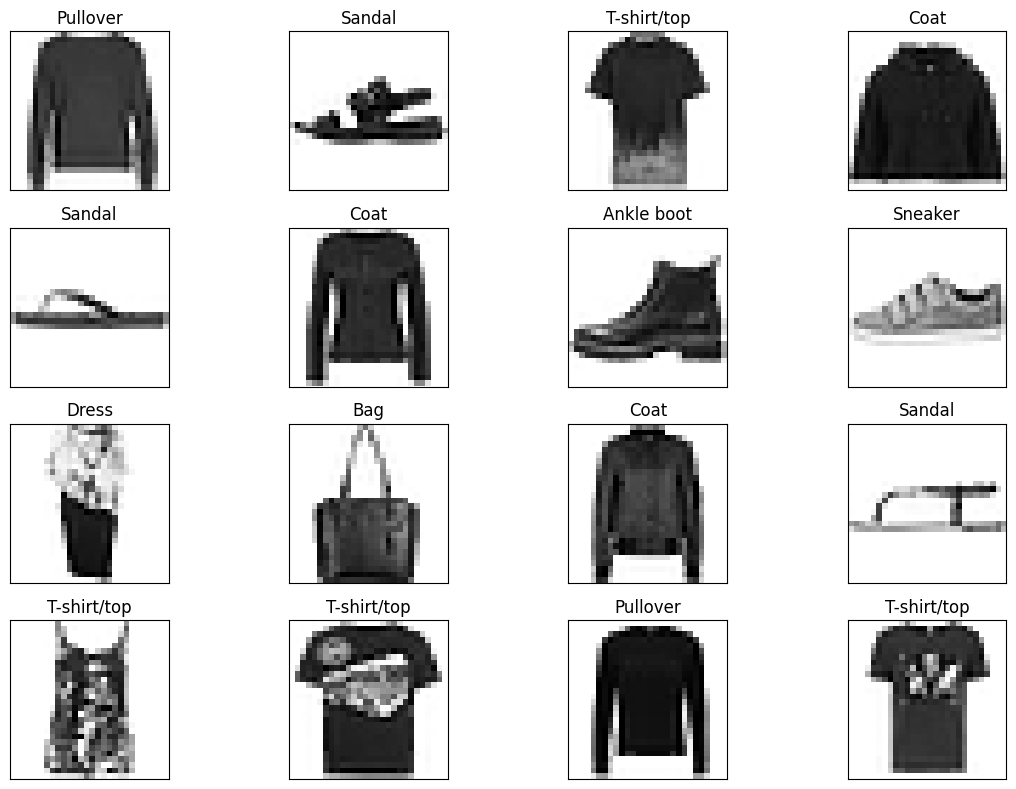

In [8]:
rows = 4
columns = 4
n = rows*columns

images = x_train[:n]
labels = y_train[:n]

fig, axes = plt.subplots(rows,
                         columns,
                         figsize=(3*columns,2*rows))

for i in range(n):
  ax = axes[i//columns, i%columns]
  ax.imshow(images[i].reshape(28,28), cmap=plt.cm.binary)
  ax.set_title('{}'.format(name_labels[np.argmax(labels[i])]))
  ax.set_xticks([]), ax.set_yticks([])
plt.tight_layout()
plt.show()

## **Data Generation**

With [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) we can apply different transformation to do data augmentation.

In [9]:
batch_size = 32

# Training set generator
gen_train = ImageDataGenerator(horizontal_flip=True,
                               vertical_flip=True,
                               height_shift_range=0.1,
                               width_shift_range=0.1,
                               fill_mode='reflect')
#  Validation set generator
gen_val = ImageDataGenerator()

data_gen_train = gen_train.flow(x_train,
                                y_train,
                                batch_size=batch_size)

data_gen_val = gen_val.flow(x_val,
                            y_val,
                            batch_size=batch_size)


- We apply data augmentation (with flip, shift and fill changes) to the training set becuase these transformations introduce variability to the data. It helps to avoid overfitting, get better robustness and have condition similar to the real world.
- We don't apply data augmentation to the validation test since we will be causing bias and worsening generalization.

We can see the result of this transformation in the train sample:

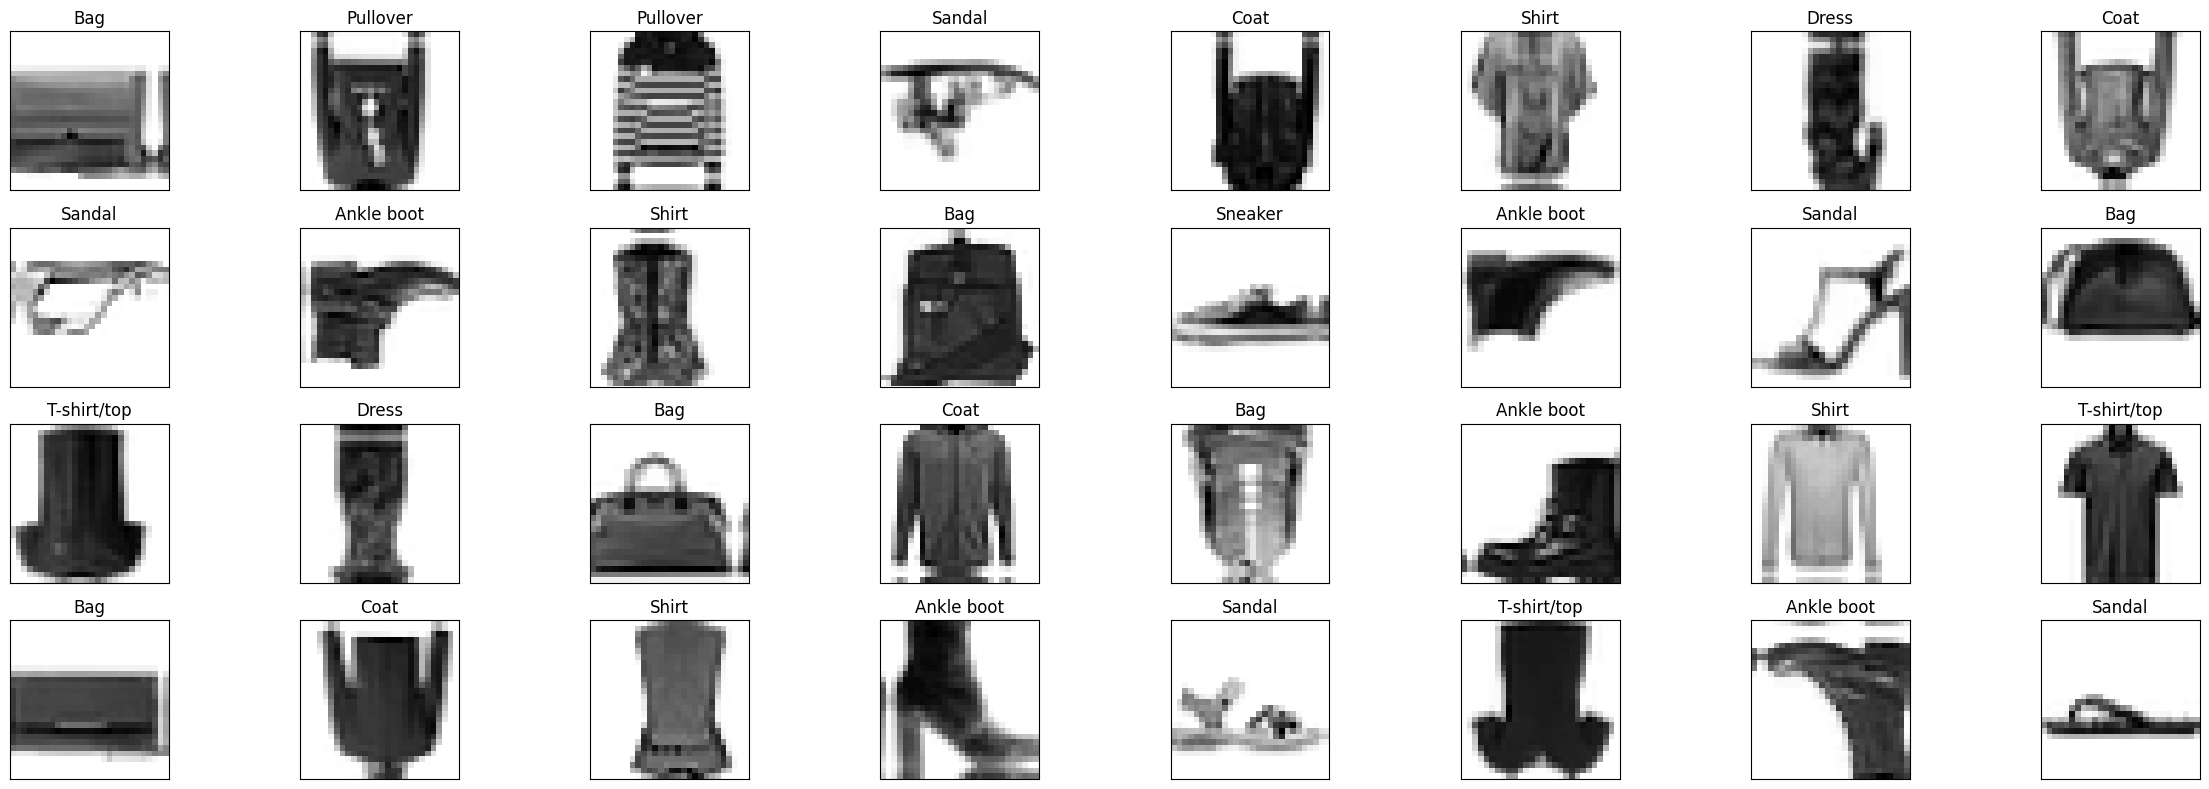

In [10]:
x_batch, y_batch = data_gen_train.__getitem__(0)

rows = 4
columns = 8
n = rows*columns

fig, axes = plt.subplots(rows,
                         columns,
                         figsize=(3*columns,2*rows))

for i in range(n):
  ax = axes[i//columns, i%columns]
  ax.imshow(x_batch[i].reshape(28,28), cmap=plt.cm.binary)
  ax.set_title('{}'.format(name_labels[np.argmax(y_batch[i])]))
  ax.set_xticks([]), ax.set_yticks([])
plt.tight_layout()
plt.show()

## **Classification model for imagens**

We will use a Convolutional Neural Net with the following characteristics:
- Convolutional layers, $k=(3,3)$
- Max pooling layers, $k=(2,2)$
- Batch normalization layers
- Flatten layers
- Dense layers
- Dropout layer

Convolutional layer will apply filters or kernel to detect patterns, learning hierchies of  features. They will operate in local regions of the image mantaining its structure.

While Max pooling layers will reduce the dimensionality, reducing also parameters and computational cost. They preserve the maximun value of each regions mantaining only the most relevant features.

Batch normalization layer helps stabilize and accelerate training by normalizing activations across a mini-batch.

Flatten layer is used to convert the multidimensional output of a convolutional or pooling layer into a 1D vector that can be fed into a fully connected (dense) layer.

A dense layer is a layer where every neuron is connected to every neuron in the previous layer. It will be use to perform classification in this case.

Finally, a Dropout layer s a regularization technique used to prevent overfitting by randomly setting a fraction of the layer’s neurons to zero during training. This forces the network to learn more robust and generalized features instead of relying too much on specific neurons.



Tensorflow Keras offers us different APIs models to implement our model: **Sequential API** and **Functional API**.

- **Sequential API**
```python
model = Sequential()
model.add(...)
model.add(...)
```
 This model is simple and better for **lineal models** with  **only one input** and **only one output**.

- **Functional API**
```python
input_layer = Input(shape=(...))
layer_1 = Dense(...)(input_layer)
layer_2 = Dense(...)(layer_1)
output_layer = Dense(...)(layer_2)
model = Model(inputs=input_layer, outputs=output_layer)
```
This model is more flexible and better for **complex models** with **multiple inputs** and **multiple outputs**

### **Function to create CNN models**

We are going to use the following layers for our classification model:

- [Conv2D](https://keras.io/api/layers/convolution_layers/convolution2d/): 2D convolutional layer where we can define the size and number of the kernels, padding option donde tenemos que definir el tamaño del kernel, padding, and the activation function.
- [BatchNormalization](https://keras.io/api/layers/normalization_layers/batch_normalization/): this layer, which applies batch normalization, doesn't have input parameters of trainable parameters since it only aims to standarize.
- [MaxPooling2D](https://keras.io/api/layers/pooling_layers/max_pooling2d/): layer that applies 2D max pooling in which we specify the size of the kernel to reduce the dimensions.
- [Dropout](https://keras.io/api/layers/regularization_layers/dropout/): layer to specifify the probability of a neuron being desactivated.

### **Experiments as our task**

When working with Deep Learning models, not only the layers are a relevant part of our modeling. The **optimizer** part of it is also crucial for adjusting the model’s weights and biases during training to minimize the loss function and improve predictions. It determines how the network learns by updating parameters based on gradients computed from the loss. They can make the convergence faster, get better generalization and stabilizes the training process.**In this part of the pipeline is where we are going to apply our experiment for this task: try different optimizer for a same model**

The original pipeline used the [Adam optimizer](https://keras.io/api/optimizers/adam/) for both Sequential and Functional APIs models. "It is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments." according to Keras website. It is also efficient since implies no high computational cost and little memory capacity, making it suitable for estimations with a large number of data or parameters. It involves a combination of two gradient descent methodologies: momentum and Root Mean Square Propagation (RMSP). The first one is used to accelerate the gradient descent algorithm by taking into consideration the ‘exponentially weighted average’ of the gradients, while the second one - RMSP - improves the AdaGrad algoritm by taking the ‘exponential moving average’.

Now, we are going to be comparing this to the [Nadam](https://keras.io/api/optimizers/Nadam/)  and the [Adagrad](https://keras.io/api/optimizers/adagrad/) in a Sequential API model that would have same parameters exceot the optimizer. Both of them also are algorithms for optimization technique for gradient descent, as like Adam is.

The Nadam optimizer is much like the Adam one, since it's essentially RMSprop with momentum but with a Nesterov momentum instead of a RSMP, which improves the convergence by anticipating the gradient direction. It does this by using an aproximation of the gradient in the point where the parameters would be after applying the momentum methodology.

In the other hand, the Adagrad optimizer has "parameter-specific learning rates, which are adapted relative to how frequently a parameter gets updated during training. The more updates a parameter receives, the smaller the updates." according to Keras description. This optimizer mantains an acumulator of squared gradients per each parameter, then divides the global learning rate by the root of the acumulator; finally it updated the weight using the adaptative learning rate.


#### **Sequential API model function**

In [11]:
# Using sequential API
def get_model(filters,
              n_classes,
              k=3,
              name="my_model",
              padding="same",
              batch_norm=False,
              dropout=None,
              optimizer=None):  # Add optimizer as a parameter
    model = Sequential(name=name)
    model.add(Input(shape=(28, 28, 1)))

    # Convolutional block 1
    model.add(Conv2D(filters[0], (k, k), activation="relu", padding=padding))
    if batch_norm:
        model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    if dropout is not None:
        model.add(Dropout(dropout))

    # More convolutional blocks
    for n in filters[1:]:
        model.add(Conv2D(n, (k, k), activation="relu", padding=padding))
        if batch_norm:
            model.add(BatchNormalization())
        model.add(MaxPooling2D(2, 2))
        if dropout is not None:
            model.add(Dropout(dropout))

    # Flatten and output layer
    model.add(Flatten())
    model.add(Dense(100, activation="relu"))
    model.add(Dense(n_classes, activation="softmax"))

    # Use the optimizer passed as a parameter (default to Adam if None)
    if optimizer is None:
        optimizer = Adam(learning_rate=0.001)  # Default optimizer

    model.compile(optimizer=optimizer,
                  loss="categorical_crossentropy",
                  metrics=['accuracy'])
    return model

#### **Functional API model function**

In [12]:
def get_model_funct(filters,
                    n_classes,
                    k=3,
                    name="my_model",
                    padding="same",
                    batch_norm=False,
                    dropout=None,
                    optimizer=None):  # Add optimizer as a parameter
    input_layer = Input(shape=(28, 28, 1))

    # Convolutional block 1
    x = Conv2D(filters[0], (k, k), activation="relu", padding=padding)(input_layer)
    if batch_norm:
        x = BatchNormalization()(x)
    x = MaxPooling2D(2, 2)(x)
    if dropout is not None:
        x = Dropout(dropout)(x)

    # More convolutional blocks
    for n in filters[1:]:
        x = Conv2D(n, (k, k), activation="relu", padding=padding)(x)
        if batch_norm:
            x = BatchNormalization()(x)
        x = MaxPooling2D(2, 2)(x)
        if dropout is not None:
            x = Dropout(dropout)(x)

    x = Flatten()(x)
    x = Dense(100, activation="relu")(x)
    output_layer = Dense(n_classes, activation="softmax")(x)

    # Define model
    model = Model(inputs=input_layer, outputs=output_layer, name=name)

    # Use the optimizer passed as a parameter (default to Adam if None)
    if optimizer is None:
        optimizer = Adam(learning_rate=0.001)  # Default optimizer

    model.compile(optimizer=optimizer,
                  loss="categorical_crossentropy",
                  metrics=['accuracy'])
    return model


### **Creating the models and defyning parameters**

We will keep the structure of one of previous models: filters of [16,32] and with batch normalization. The only change implemented here would be definition of the optimizer.  

In [13]:
model_cnn_1 = get_model(filters=[16,32],
                        n_classes=n_classes,
                        name="CNN_1",
                        batch_norm = True,
                        optimizer=Adam(learning_rate=0.001))

model_cnn_2 = get_model(filters=[16,32],
                        n_classes=n_classes,
                        name="CNN_2",
                        batch_norm=True,
                        optimizer=Nadam(learning_rate=0.001))

model_cnn_3 = get_model(filters=[16,32],
                        n_classes=n_classes,
                        name="CNN_3",
                        batch_norm=True,
                        optimizer=Adagrad(learning_rate=0.001))



### **Number of parameters**

In [14]:
model_cnn_1.summary()
print("\n\n")
model_cnn_2.summary()
print("\n\n")
model_cnn_3.summary()

Model: "CNN_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 28, 28, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 14, 14, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1568)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │         156,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 162,902 (636.34 KB)

 Trainable params: 162,806 (635.96 KB)

 Non-trainable params: 96 (384.00 B)

Model: "CNN_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 14, 14, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1568)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 100)                 │         156,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 162,902 (636.34 KB)

 Trainable params: 162,806 (635.96 KB)

 Non-trainable params: 96 (384.00 B)

Model: "CNN_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 28, 28, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 28, 28, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 14, 14, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 14, 14, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1568)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 100)                 │         156,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 162,902 (636.34 KB)

 Trainable params: 162,806 (635.96 KB)

 Non-trainable params: 96 (384.00 B)

In [15]:
print("Model:{}, Parameters:{}".format(model_cnn_1.name,
                                       model_cnn_1.count_params()))

print("Model:{}, Parameters:{}".format(model_cnn_2.name,
                                       model_cnn_2.count_params()))

print("Model:{}, Parameters:{}".format(model_cnn_3.name,
                                       model_cnn_3.count_params()))

Model:CNN_1, Parameters:162902
Model:CNN_2, Parameters:162902
Model:CNN_3, Parameters:162902


As you can see, the structure of the models would be the same for all, a Sequential API with 2 convolutional blocks, [16, 32] kernels, batch normalization and max pooling. This also means that the number of parameters estimated for each one would be the same (162,902). The only diffference would be the optimizer, which results would be found in the graphs down on the pipeline.

Let's remember that model 1 holds an Adam optimizer, model 2 a Nadam optimizer and model 3 a Agradad optimizer. Since the first and second model hold a similar optimizers, I'll expect that they would have similar results.

### **Model's visualization**

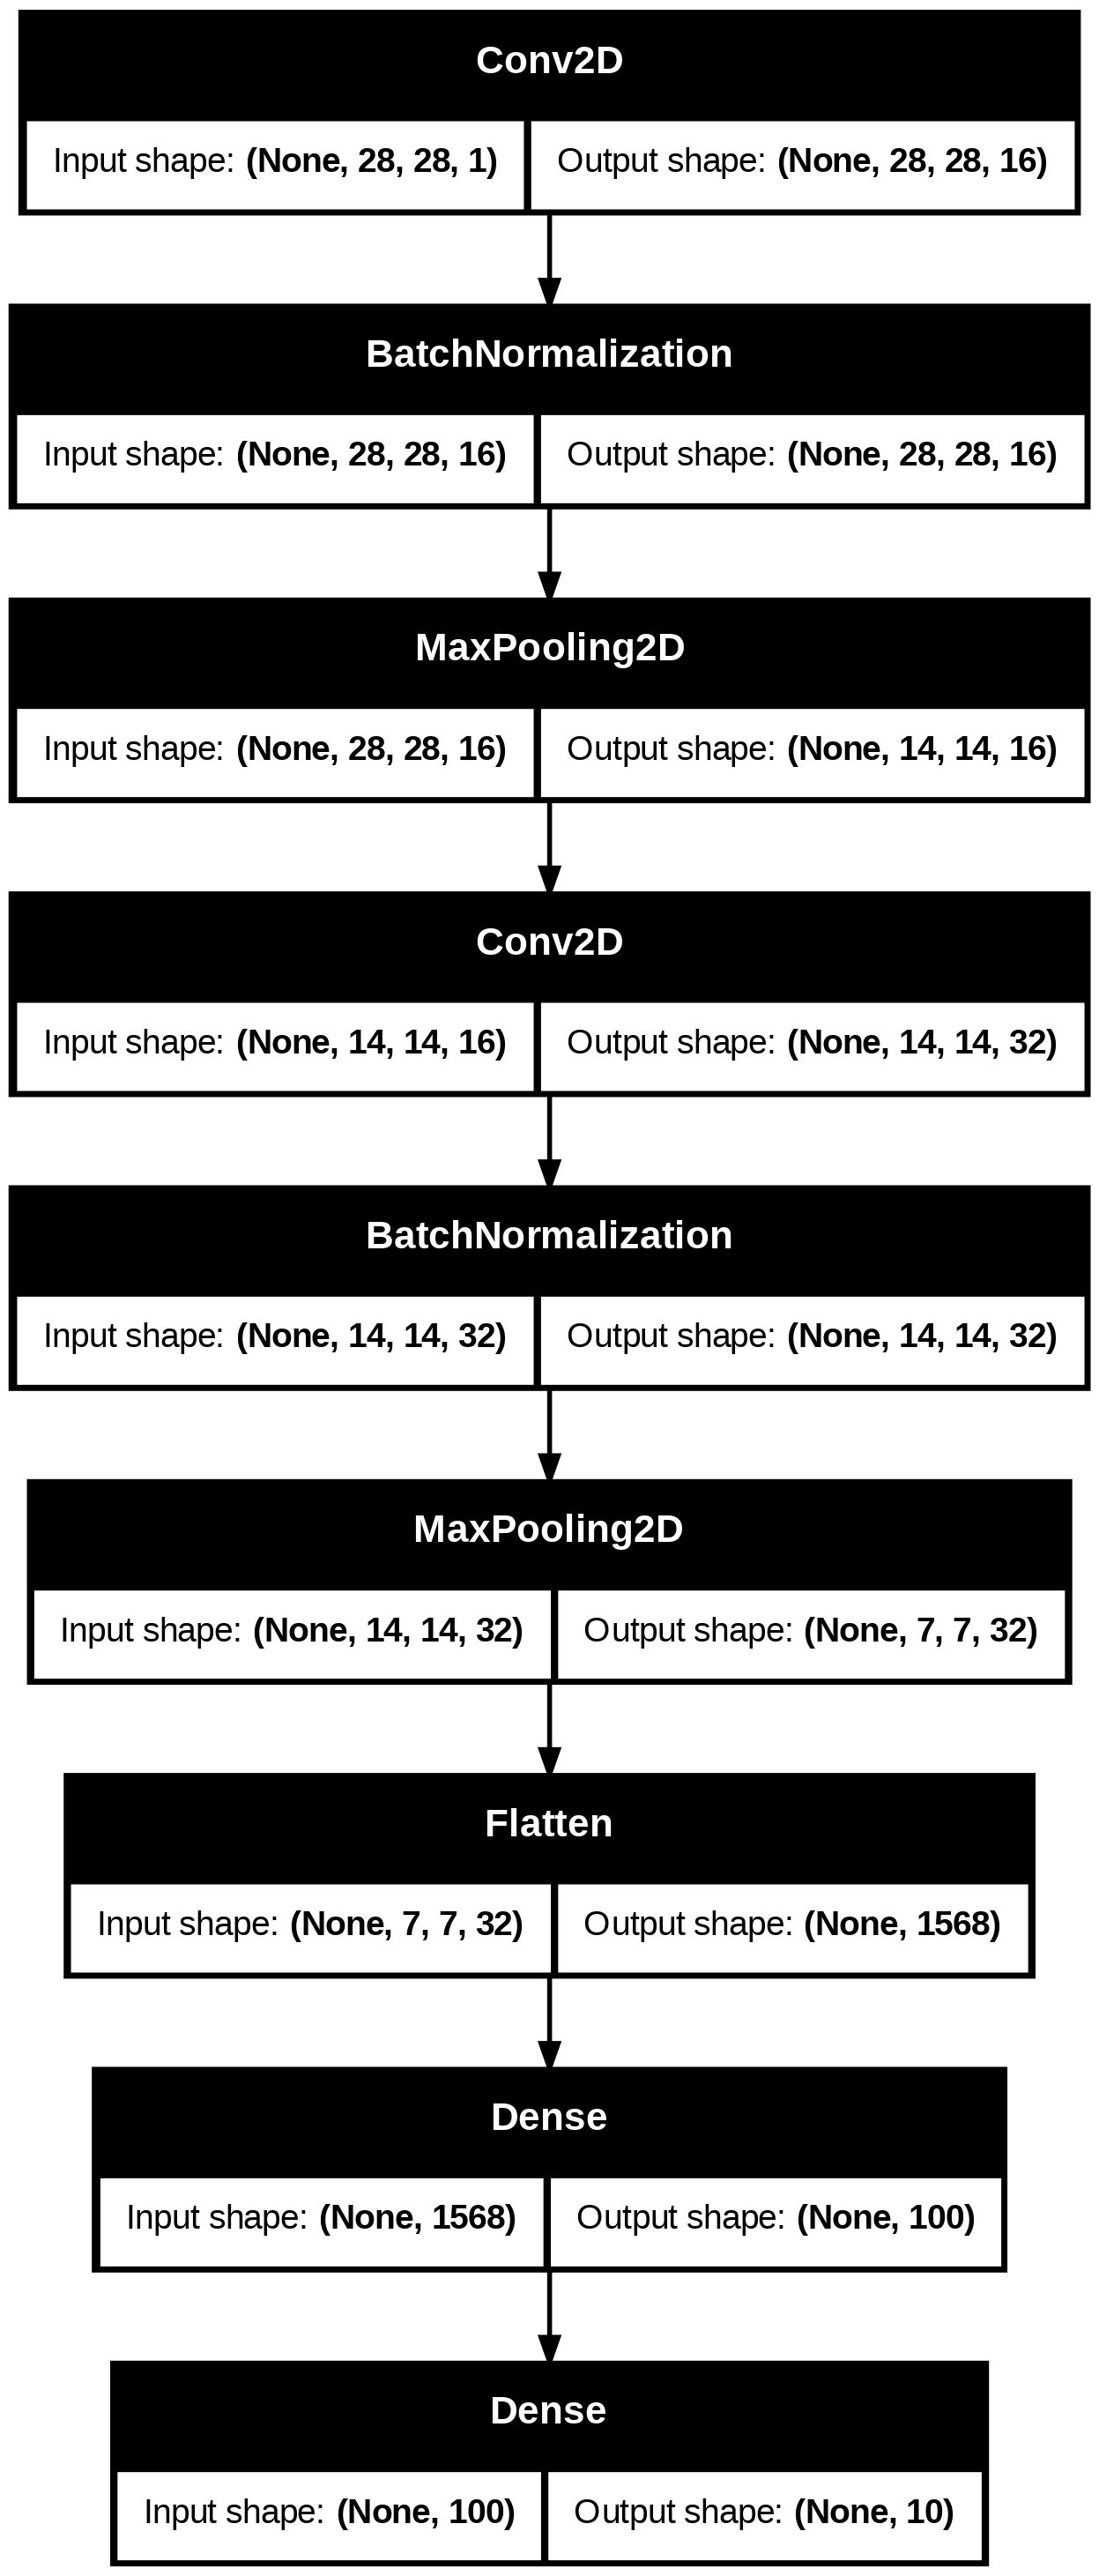

In [16]:
plot_model(model_cnn_1, to_file="model_cnn_1.png", show_shapes=True)

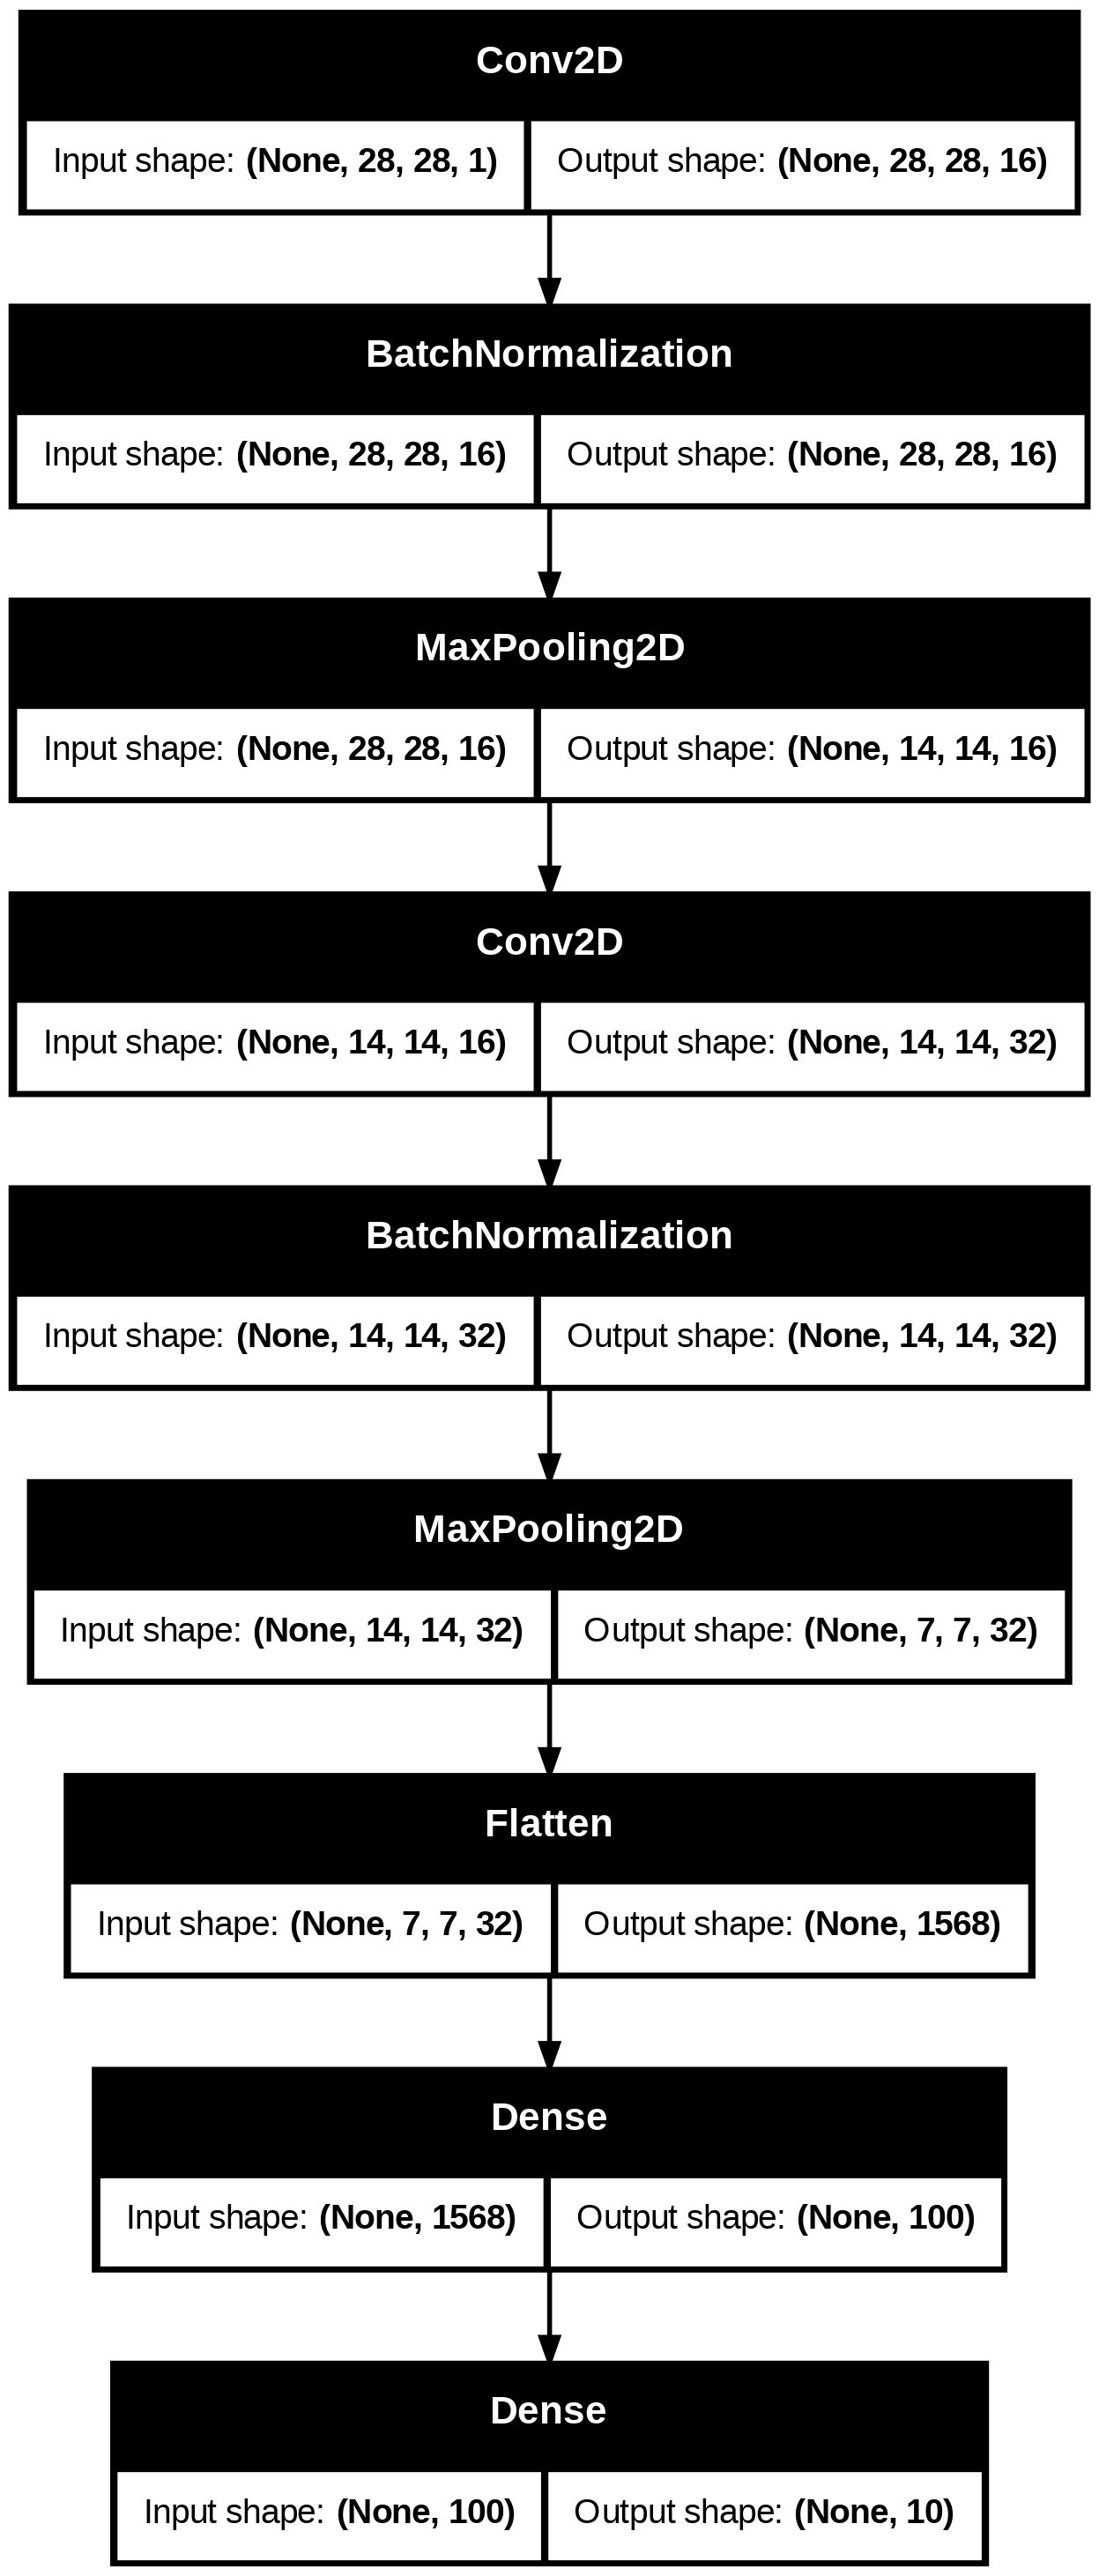

In [17]:
plot_model(model_cnn_2, to_file="model_cnn_2.png", show_shapes=True)

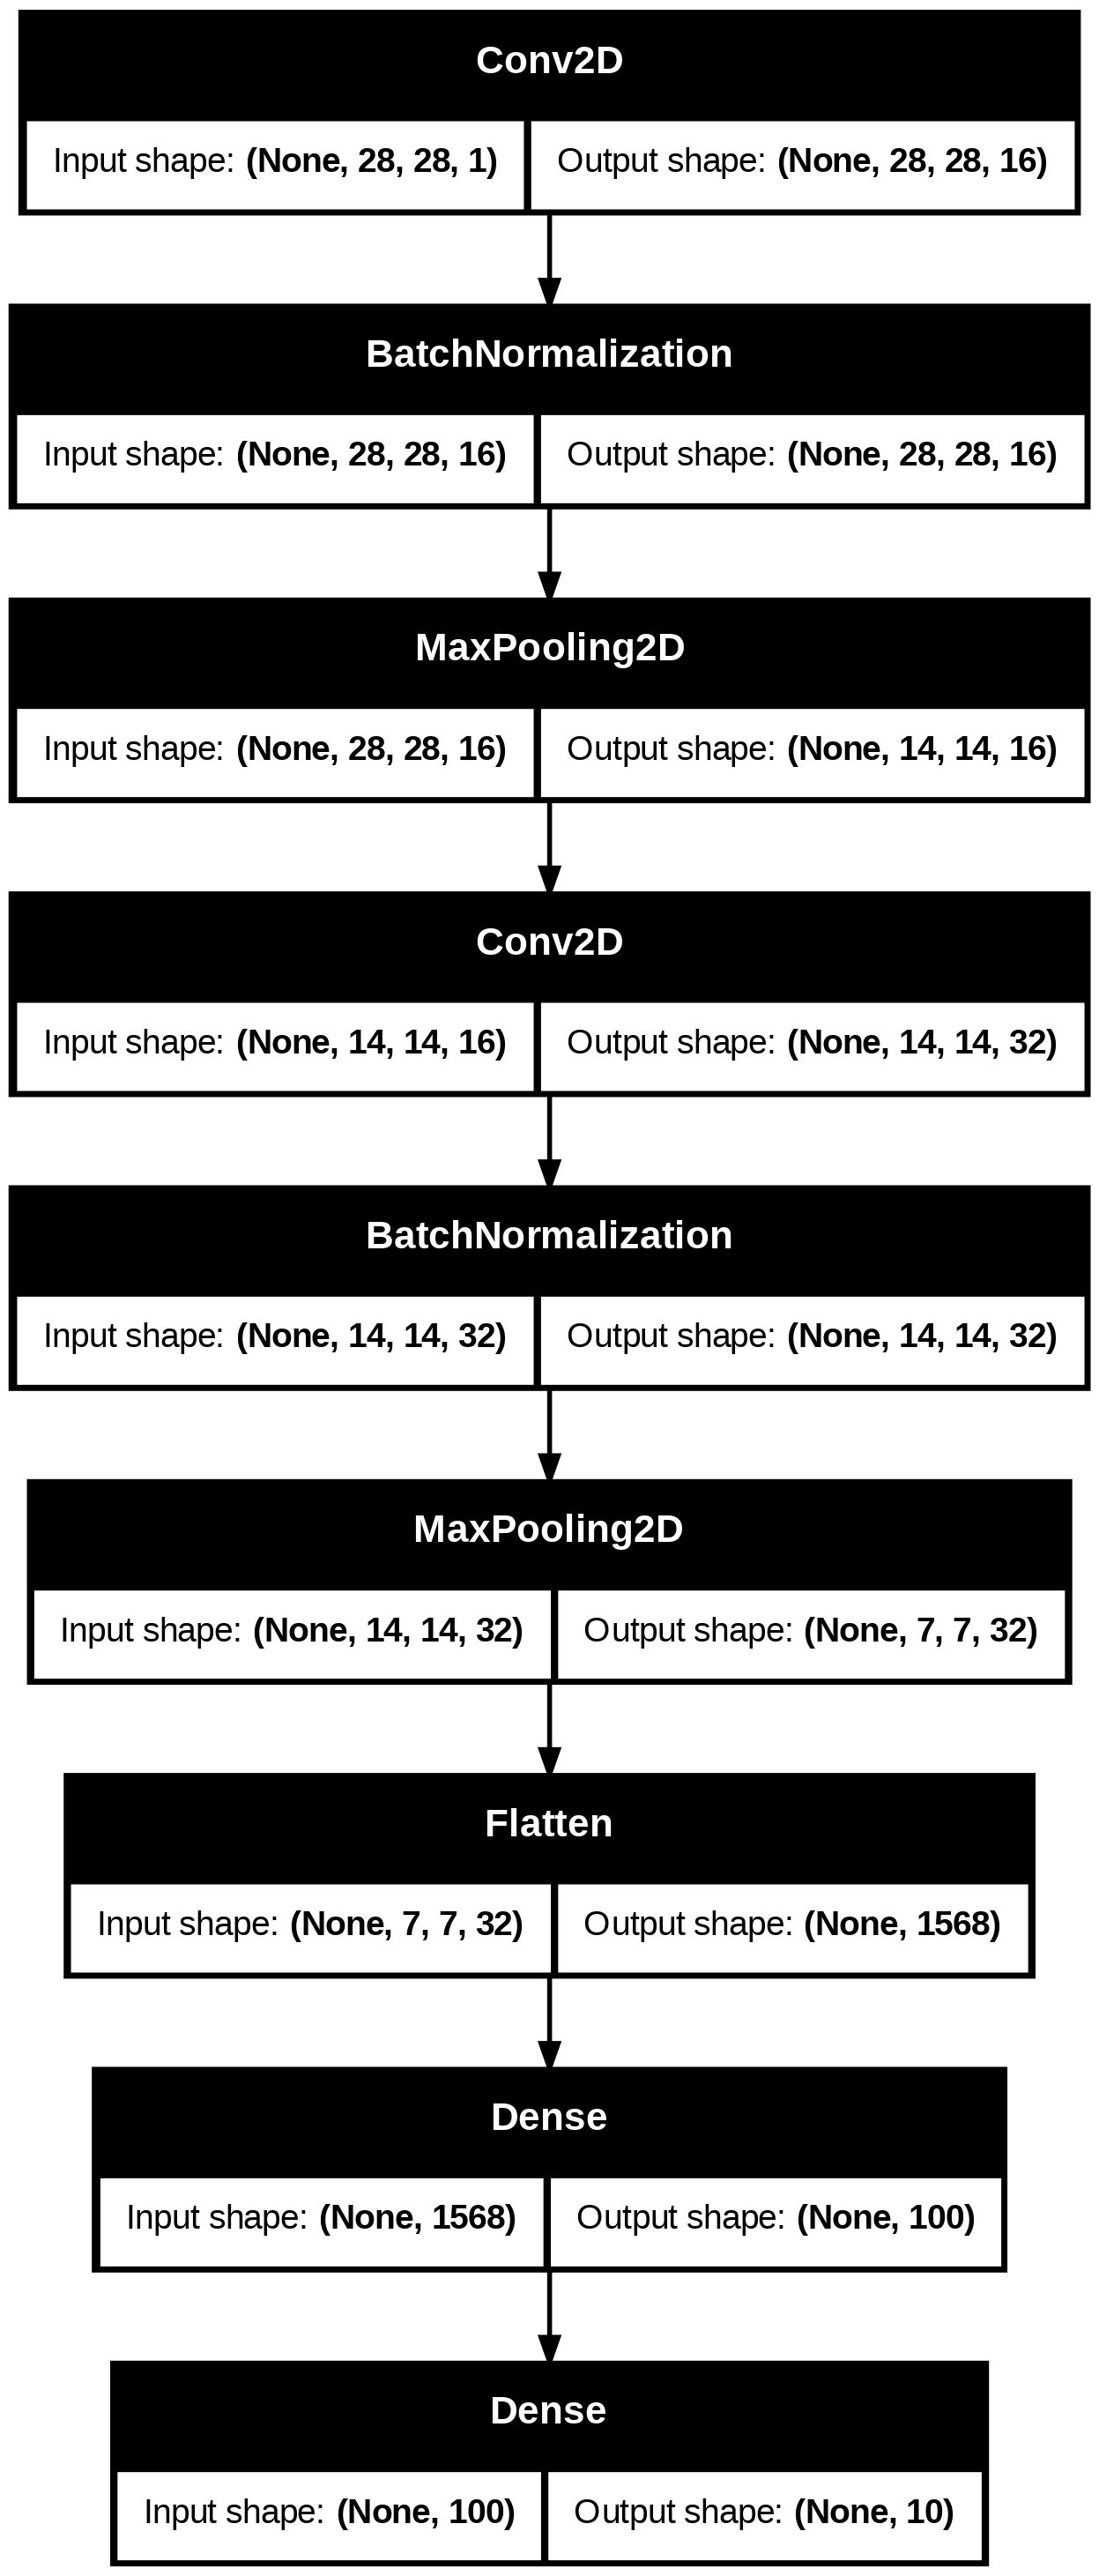

In [18]:
plot_model(model_cnn_3, to_file="model_cnn_3.png", show_shapes=True)

## **Training configuration**

We will use [callbacks](https://keras.io/api/callbacks/) during out training process:
- [ModelCheckpoint](https://keras.io/api/callbacks/model_checkpoint/): saves the best model according to out chose metric (Accuracy).
- [EarlyStopping](https://keras.io/api/callbacks/early_stopping/): stops the training process of the model if the metric hasn't improved after a determined number of epochs.

In [19]:
def get_ckpt(ckpt_name):
  return ModelCheckpoint(ckpt_name,
                         mode="max",
                         save_best_only=True,
                         monitor="val_accuracy",
                         verbose=1)

def get_earlystop(patience=10):
  return EarlyStopping(patience=patience,
                       verbose=1,
                       mode="max",
                       restore_best_weights=True,
                       monitor="val_accuracy")

In [20]:
# Callbacks
# ModelCheckpoint guardara el modelo cada vez que exista una mejora
# en el accuracy del conjunto de validación
mode_autosave_cnn_1 = get_ckpt("classification_model_cnn_1.keras")
mode_autosave_cnn_2 = get_ckpt("classification_model_cnn_2.keras")
mode_autosave_cnn_3 = get_ckpt("classification_model_cnn_3.keras")

# EarlyStopping terminara el entrenamiento si no existe una mejora
# en el accuracy en 40 epocas
earlystop_cnn_1 = get_earlystop(patience=10)
earlystop_cnn_2 = get_earlystop(patience=10)
earlystop_cnn_3 = get_earlystop(patience=10)

callbacks_cnn_1 = [mode_autosave_cnn_1, earlystop_cnn_1]
callbacks_cnn_2 = [mode_autosave_cnn_2, earlystop_cnn_2]
callbacks_cnn_3 = [mode_autosave_cnn_3, earlystop_cnn_3]

## **Models' Training**

Takes around half an hour to run 3 models with modifications.

Hypothesis: Since Adam is the base model,  we would expect that Nadam - which is a similar but more efficient optimizer - would perfom better than it. At the same time, we would expect Adagrad to perform wrost than Adams since the latter holds two methodoloys to improve its convergence, and one of them is the former.

In [21]:
history_cnn_1 = model_cnn_1.fit(data_gen_train,
                                epochs=200,
                                validation_data=data_gen_val,
                                callbacks=callbacks_cnn_1
                                )

Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1687/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7116 - loss: 0.7930
Epoch 1: val_accuracy improved from -inf to 0.82450, saving model to classification_model_cnn_1.keras
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 38s 18ms/step - accuracy: 0.7117 - loss: 0.7928 - val_accuracy: 0.8245 - val_loss: 0.5135
Epoch 2/200
1685/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8245 - loss: 0.4672
Epoch 2: val_accuracy improved from 0.82450 to 0.86767, saving model to classification_model_cnn_1.keras
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.8245 - loss: 0.4671 - val_accuracy: 0.8677 - val_loss: 0.3791
Epoch 3/200
1685/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8476 - loss: 0.4150
Epoch 3: val_accuracy improved from 0.86767 to 0.87617, saving model to classification_model_cnn_1.keras
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.8476 - loss: 0.4149 - val_accuracy: 0.8762 - val_loss: 0.3431
Epoch 4/200
1686/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy:

In [22]:
history_cnn_2 = model_cnn_2.fit(data_gen_train,
                                epochs=200,
                                validation_data=data_gen_val,
                                callbacks=callbacks_cnn_2
                                )

Epoch 1/200
1687/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7172 - loss: 0.7800
Epoch 1: val_accuracy improved from -inf to 0.83883, saving model to classification_model_cnn_2.keras
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 27s 13ms/step - accuracy: 0.7173 - loss: 0.7798 - val_accuracy: 0.8388 - val_loss: 0.4324
Epoch 2/200
1684/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8295 - loss: 0.4572
Epoch 2: val_accuracy improved from 0.83883 to 0.85267, saving model to classification_model_cnn_2.keras
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 37s 12ms/step - accuracy: 0.8295 - loss: 0.4572 - val_accuracy: 0.8527 - val_loss: 0.4133
Epoch 3/200
1685/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8482 - loss: 0.4024
Epoch 3: val_accuracy improved from 0.85267 to 0.85883, saving model to classification_model_cnn_2.keras
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.8482 - loss: 0.4024 - val_accuracy: 0.8588 - val_loss: 0.3757
Epoch 4/200
1684/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

In [23]:
history_cnn_3 = model_cnn_3.fit(data_gen_train,
                                epochs=200,
                                validation_data=data_gen_val,
                                callbacks=callbacks_cnn_3
                                )

Epoch 1/200
1687/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5991 - loss: 1.1458
Epoch 1: val_accuracy improved from -inf to 0.75700, saving model to classification_model_cnn_3.keras
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.5992 - loss: 1.1455 - val_accuracy: 0.7570 - val_loss: 0.6869
Epoch 2/200
1685/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7458 - loss: 0.7050
Epoch 2: val_accuracy improved from 0.75700 to 0.77850, saving model to classification_model_cnn_3.keras
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.7458 - loss: 0.7050 - val_accuracy: 0.7785 - val_loss: 0.6201
Epoch 3/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7649 - loss: 0.6494
Epoch 3: val_accuracy did not improve from 0.77850
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.7649 - loss: 0.6494 - val_accuracy: 0.7735 - val_loss: 0.6282
Epoch 4/200
1686/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7726 - loss: 0.6254
Epoch 4: val_accura

In [24]:
print(history_cnn_1.history.keys())
print(history_cnn_2.history.keys())
print(history_cnn_3.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


## **Evolution of the models during the trainning process (measured in epochs)**

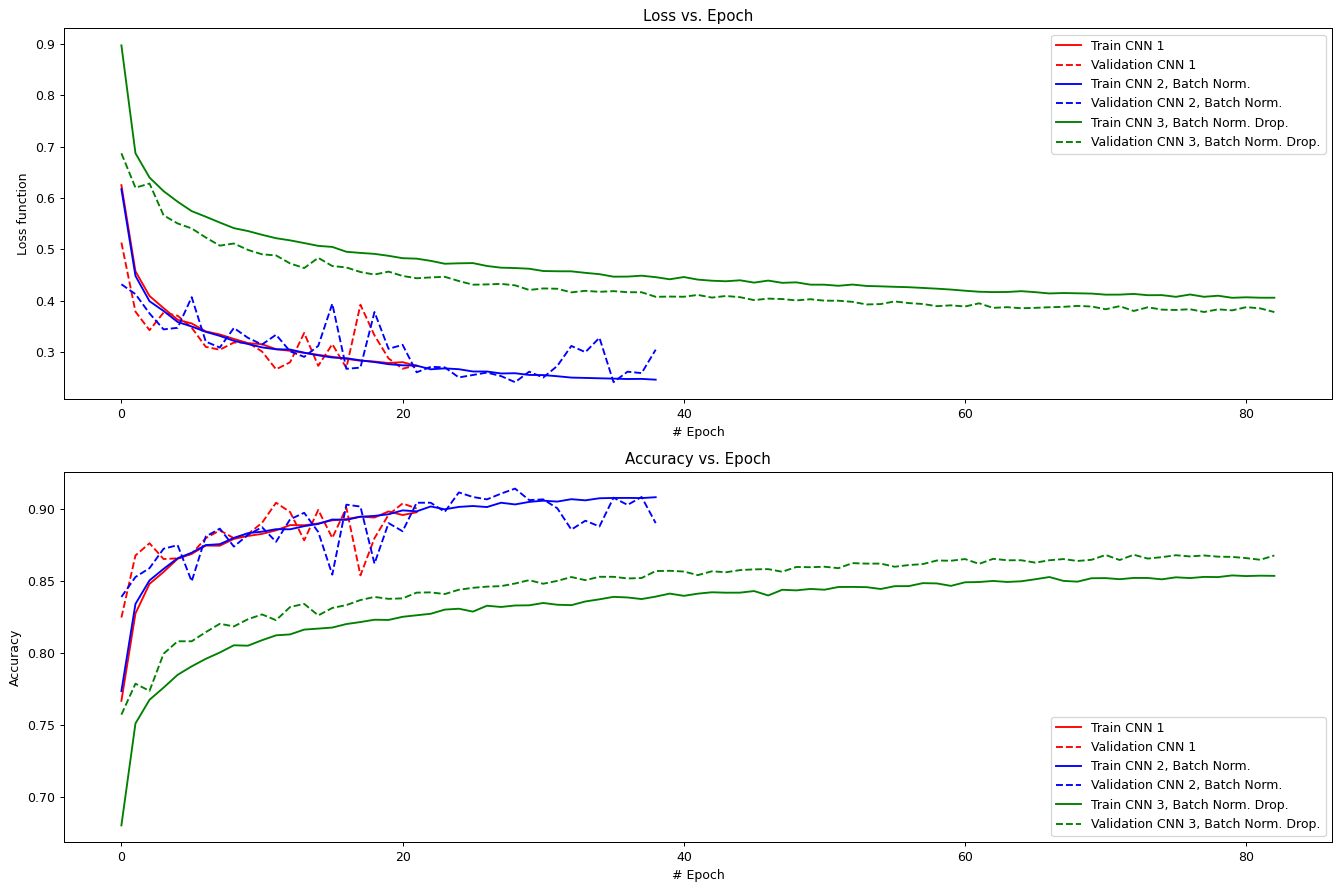

In [25]:
fig_labels = ["Train CNN 1",
              "Validation CNN 1",
              "Train CNN 2, Batch Norm.",
              "Validation CNN 2, Batch Norm.",
              "Train CNN 3, Batch Norm. Drop.",
              "Validation CNN 3, Batch Norm. Drop."]

plt.figure(figsize=(15,10), dpi=90)

plt.subplot(2,1,1)
plt.plot(history_cnn_1.history["loss"], "r-")
plt.plot(history_cnn_1.history["val_loss"], "r--")
plt.plot(history_cnn_2.history["loss"], "b-")
plt.plot(history_cnn_2.history["val_loss"], "b--")
plt.plot(history_cnn_3.history["loss"], "g-")
plt.plot(history_cnn_3.history["val_loss"], "g--")
plt.xlabel("# Epoch")
plt.ylabel("Loss function")
plt.legend(fig_labels)
plt.title("Loss vs. Epoch")

plt.subplot(2,1,2)
plt.plot(history_cnn_1.history["accuracy"], "r-")
plt.plot(history_cnn_1.history["val_accuracy"], "r--")
plt.plot(history_cnn_2.history["accuracy"], "b-")
plt.plot(history_cnn_2.history["val_accuracy"], "b--")
plt.plot(history_cnn_3.history["accuracy"], "g-")
plt.plot(history_cnn_3.history["val_accuracy"], "g--")
plt.xlabel("# Epoch")
plt.ylabel("Accuracy")
plt.legend(fig_labels)
plt.title("Accuracy vs. Epoch")

plt.tight_layout()

plt.show()

#Results for training process


Note: Model 1 holds an Adam optimizer, model 2 a Nadam optimizer and model 3 a Agradad optimizer.

#The loss graph

The Loss is a scalar value that represents the error or discrepancy between the model's predictions and the true labels. From the loss vs epoch figure we can see that there's is considerable difference between model 1 and model 2 in comparison to model 3.  This first 2 models also seem to have smaller losses than model 3 in a all the number of epochs, for both training ans test sets. This was part of what we expected: Adams and Nadam optimizer perfoming better than the simple-but-good Adagrad.

The first 2 models losses are closer and follow a same pattern and number of epochs in the convergence process, althought model 1 needs less epochs to find the ideal weights than model 2. As Adams and Nadam optimizer share the momentun methodology, it makes sense that they are similar.

However, we can see that if we compare training and validation test results for model 1 and model 2, the difference is not always consistent: sometimes the training set has lower loss values than the validation one. This happens more in model 1 than in model 2 for the amounts of epochs they share. The result aligns of what we know about the Nadam optimizer: it aims to stabilize the convergence and it has slighlty better results than the Adam optimizer. However, the fact that it is not always true that the validation set has higher losses than the training set results should flag that there's probably some overfitting happenning in the trainin process. We would expect that the validation set has higher values or at least equal values than the training set always since this would imply that the model is perfoming better or equal than in the training set. However, since this is not always happenning, it means that sometimes the model has overlearned the information in the training set and is not so good at generalizing outsite of it (like in the validation set).

As for model 3, we can see a clear difference between the loss results in training and validation sets: the former always has smaller loss values than the latter one. This ia great example of overfitting since the difference in both dataset is clear along the curve (probably graphing the lower and upper bounds would give us a prove of significance for this). This shows that Adagrad not only has a smaller losses values along the training, it also overfits its model to the training data, having worst generalization.

Overall, we can see that all the models start with a low loss and then begins to decrease until there is no more testing thanks to the callbacks, althought the testing ends before for model 1 and 2 than for 3. The fact that all models still converge, but just at different rates and with different loss results ,show us that the experiment, which was trying to compare similar optimizer, makes sense. This is because we were comparing ways of convergence for a model ( model1) that we knew it converged by changing the optimizer.

#The accuracy graph

Accuracy is the ratio of correctly predicted instances to the total number of instances. The accuracy vs epoch figure has consistentent results with the previous loss figure. The difference between model 1 and model 2 in comparison to model 3 still remains. This first 2 models also seem to have bigger value for accuracy metric than the third model in a all the number of epochs, still for both sets.
The first 2 models' accuracy are next to each other,  and  their function follow a same pattern and number of epochs in the convergence process. The results of Adam and Ndam optimizer remains, as well as the underperfomance expected by Adagrad.

We can still notice that  the training and validation test results for both models keep being inconsistent because in some epoch values the accuracy values are higher for the training set than for the validation one. We can see a clear difference between the accuracy values in training and validation sets for model 3, where the latter has higher values than the latter always. The stabilization of Nadam's model still can be seen although the ocasional overfitting for the Adam and Nadam optimizers too, as well as the general overfitting for the Adagrad optimizer.

As above, we can see that all the models get higher accuracy values with the past of epochs until this measure doesn't improves anymore. We keep getting convergence with the Adam, Nadam and Adagrad optimizers.

## **Sacing weights of the model**

We can begin loading the models in order no to repeat training steps

In [26]:
model_cnn_1 = keras.models.load_model("classification_model_cnn_1.keras")
model_cnn_2 = keras.models.load_model("classification_model_cnn_2.keras")
model_cnn_3 = keras.models.load_model("classification_model_cnn_3.keras")

## **Testing the model**

Define a data for the test set.

In [27]:
gen_test = ImageDataGenerator()

data_gen_test = gen_test.flow(x_test,
                               y_test,
                               batch_size=batch_size)

Estimate the metrics and the value of the loss function per model in all sets: training, validation and test.

In [28]:
print("Entrenamiento:")
scores_train_1 = model_cnn_1.evaluate(data_gen_train)
scores_train_2 = model_cnn_2.evaluate(data_gen_train)
scores_train_3 = model_cnn_3.evaluate(data_gen_train)

print("Validación:")
scores_val_1 = model_cnn_1.evaluate(data_gen_val)
scores_val_2 = model_cnn_2.evaluate(data_gen_val)
scores_val_3 = model_cnn_3.evaluate(data_gen_val)

print("Pruebas:")
scores_test_1 = model_cnn_1.evaluate(data_gen_test)
scores_test_2 = model_cnn_2.evaluate(data_gen_test)
scores_test_3 = model_cnn_3.evaluate(data_gen_test)

Entrenamiento:
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.8802 - loss: 0.3195
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.8953 - loss: 0.2825
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.8508 - loss: 0.4061
Validación:
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9057 - loss: 0.2615
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9147 - loss: 0.2388
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8658 - loss: 0.3847
Pruebas:
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8953 - loss: 0.2885
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9089 - loss: 0.2613
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8552 - loss: 0.4219


In [29]:
print("Entrenamiento:")
print("CNN1: loss: {:.4f}, accuracy: {:.2f}".format(scores_train_1[0], 100*scores_train_1[1]))
print("CNN2: loss: {:.4f}, accuracy: {:.2f}".format(scores_train_2[0], 100*scores_train_2[1]))
print("CNN3: loss: {:.4f}, accuracy: {:.2f}".format(scores_train_3[0], 100*scores_train_3[1]))

print("Validación:")
print("CNN1: loss: {:.4f}, accuracy: {:.2f}".format(scores_val_1[0], 100*scores_val_1[1]))
print("CNN2: loss: {:.4f}, accuracy: {:.2f}".format(scores_val_2[0], 100*scores_val_2[1]))
print("CNN3: loss: {:.4f}, accuracy: {:.2f}".format(scores_val_3[0], 100*scores_val_3[1]))

print("Pruebas:")
print("CNN1: loss: {:.4f}, accuracy: {:.2f}".format(scores_test_1[0], 100*scores_test_1[1]))
print("CNN2: loss: {:.4f}, accuracy: {:.2f}".format(scores_test_2[0], 100*scores_test_2[1]))
print("CNN3: loss: {:.4f}, accuracy: {:.2f}".format(scores_test_3[0], 100*scores_test_3[1]))

Entrenamiento:
CNN1: loss: 0.3201, accuracy: 88.09
CNN2: loss: 0.2803, accuracy: 89.60
CNN3: loss: 0.4079, accuracy: 85.19
Validación:
CNN1: loss: 0.2670, accuracy: 90.43
CNN2: loss: 0.2421, accuracy: 91.42
CNN3: loss: 0.3805, accuracy: 86.82
Pruebas:
CNN1: loss: 0.2820, accuracy: 89.69
CNN2: loss: 0.2638, accuracy: 90.72
CNN3: loss: 0.4016, accuracy: 85.71


#**Results all sets**

| **Métrica**      | **CNN1**            | **CNN2**            | **CNN3**            |
|------------------|---------------------|---------------------|---------------------|
| **Entrenamiento**|                     |                     |                     |
| - Loss           | 0.2480              | 0.2228              | 0.4084              |
| - Accuracy       | 90.77%              | 91.74%              | 85.31%              |
| **Validación**   |                     |                     |                     |
| - Loss           | 0.2394              | 0.2134              | 0.3829              |
| - Accuracy       | 91.57%              | 91.93%              | 86.47%              |
| **Pruebas**      |                     |                     |                     |
| - Loss           | 0.2585              | 0.2487              | 0.4041              |
| - Accuracy       | 90.74%              | 90.96%              | 85.68%              |

As we expected, model 2, that uses the Nadam optimizer, holds a slightly higher value of our metric - accuracy- and a slightly smaller loss value than the Adam optimizer model results. Also, we can see that the Adagrad optimizer model underperforms both of this models since it has a smaller accuracy value and a higher loss value.

As we have argued before, the Adams and Nadam models, due to the similar structure and methodologies, expose similar perfomance. However, the Nadam,  due to the RSMP change, show an almost unnoticiable improvement. At the same time, the Adagrad optimized results have a clear distance of this 2 models, since the optimizer is simplier and a "regression" in the algorithm that Adam and Nadam use.

## **Visualización**

### **Kernels**

Capa: conv2d (3, 3, 1, 16)


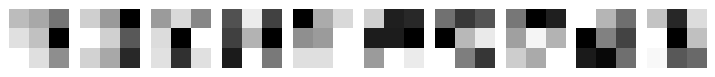

Capa: conv2d_1 (3, 3, 16, 32)


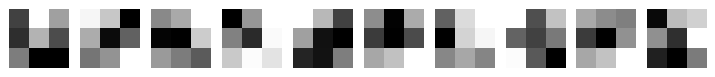

In [30]:
for layer in model_cnn_1.layers:
  # filtrando las capas convolucionales
  if "conv2d" in layer.name:
    filters, biases = layer.get_weights()
    print("Capa:", layer.name, filters.shape)

    # normalizando los valores entre 0 y 1
    # solo para visualización
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)

    # visualizando los kernels
    n_filters = 10
    n_bands = 1
    plt.figure(figsize=(10,10), dpi=90)
    for i in range(n_filters):
      f = filters[:,:,:n_bands,i]
      plt.subplot(1,n_filters,i+1)
      plt.imshow(f, cmap="gray")
      plt.axis("off")
    plt.show()

### **Feature maps**

In [31]:
idx = []
for i in range(len(model_cnn_1.layers)):
  layer = model_cnn_1.layers[i]
  # filtrando las capas convolucionales
  if "conv2d" in layer.name:
    idx.append(i)
    print("Capa:", i, layer.name, layer.output.shape)

outputs = [model_cnn_1.layers[i+1].output for i in idx]
model_cnn_1 = Model(inputs=model_cnn_1.inputs, outputs=outputs)
model_cnn_1.summary()

Capa: 0 conv2d (None, 28, 28, 16)
Capa: 3 conv2d_1 (None, 14, 14, 32)


Model: "functional_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 28, 28, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 28, 28, 16)     │            160 │ input_layer[0][0],     │
│                           │                        │                │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 28, 28, 16)     │             64 │ conv2d[1][0],          │
│ (BatchNormalization)      │                        │                │ conv2d[4][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 14, 14, 16)     │              0 │ batch_normalization[3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 14, 14, 32)     │          4,640 │ max_pooling2d[2][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 14, 14, 32)     │            128 │ conv2d_1[1][0]         │
│ (BatchNormalization)      │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,992 (19.50 KB)

 Trainable params: 4,896 (19.12 KB)

 Non-trainable params: 96 (384.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(32, 28, 28, 1))
  warnings.warn(msg)


Muestra: 0


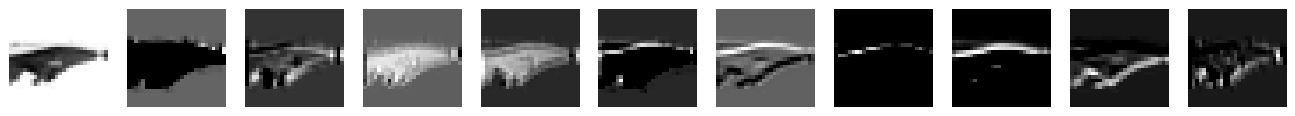

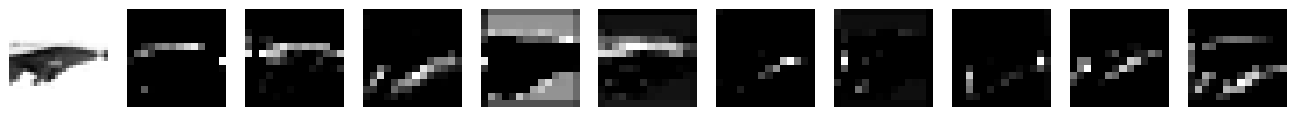

Muestra: 1


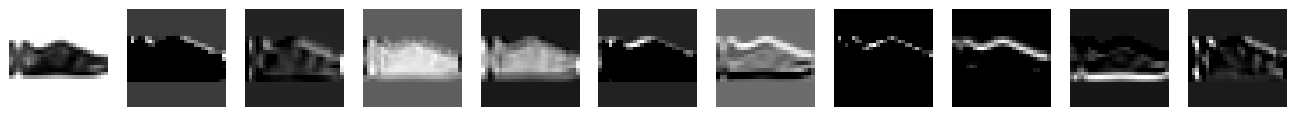

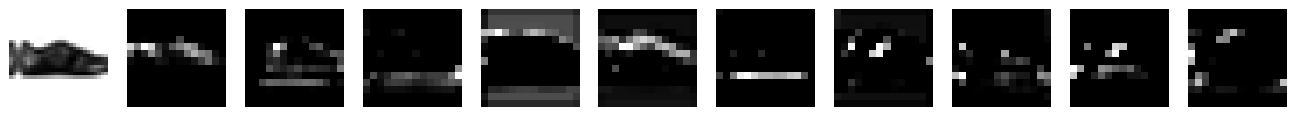

Muestra: 2


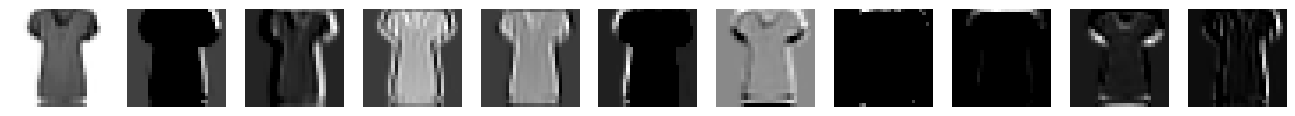

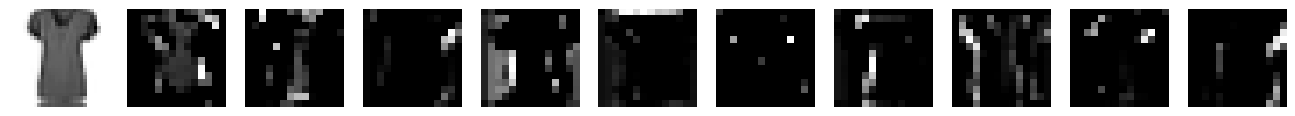

Muestra: 3


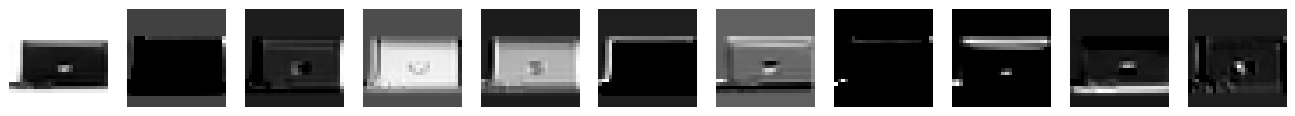

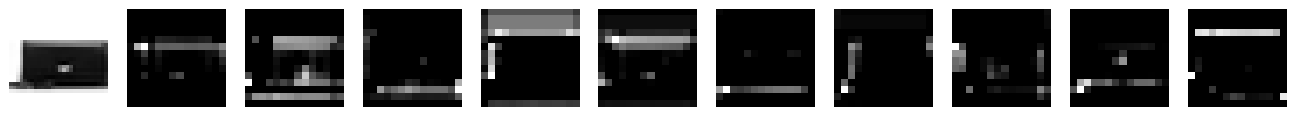

Muestra: 4


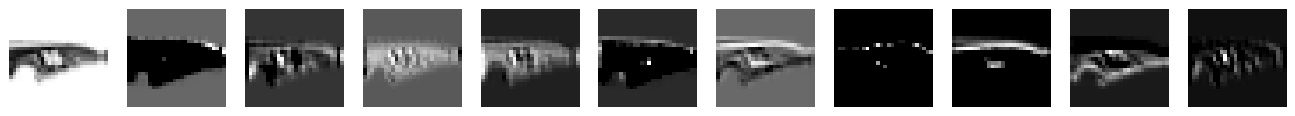

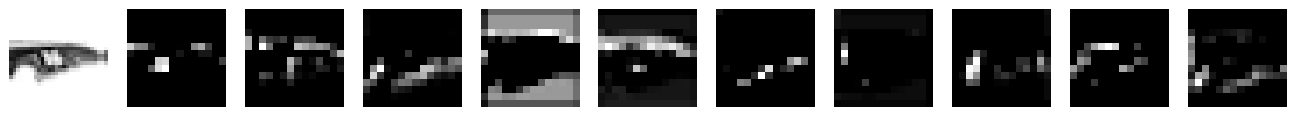

Muestra: 5


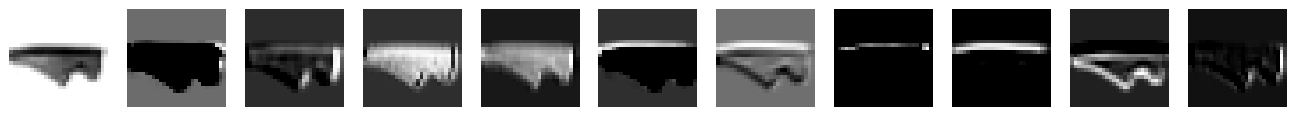

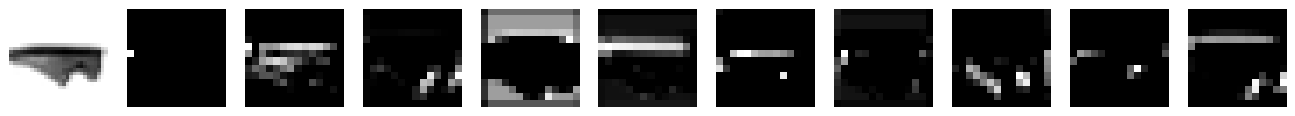

Muestra: 6


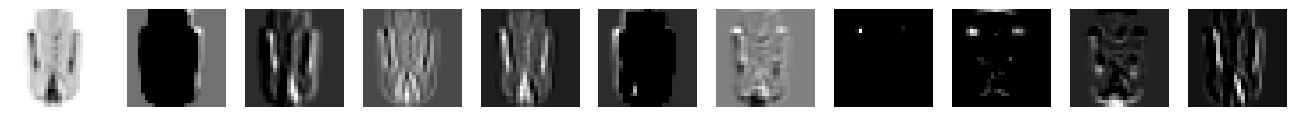

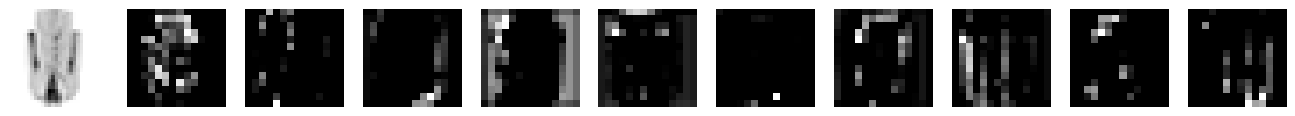

Muestra: 7


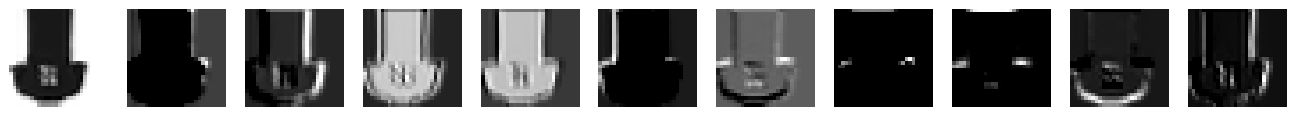

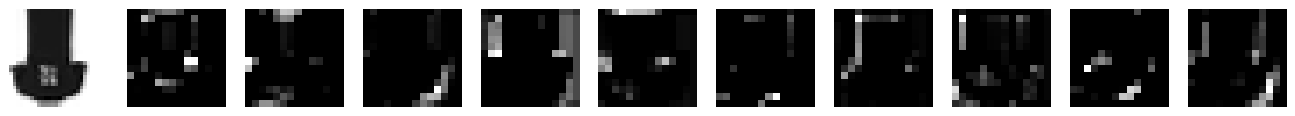

Muestra: 8


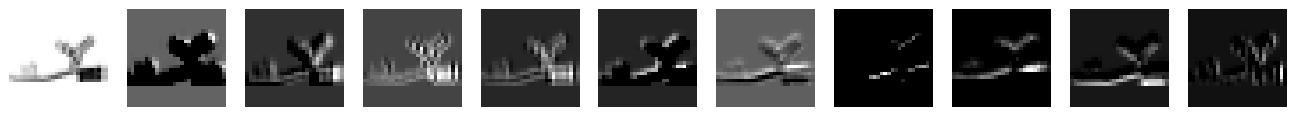

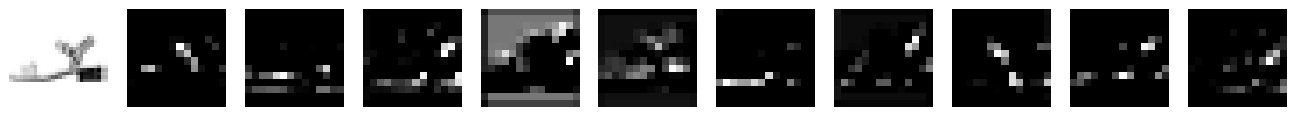

Muestra: 9


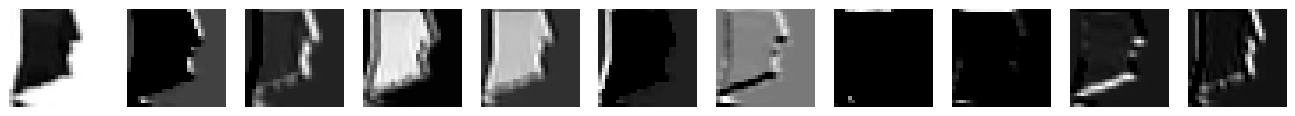

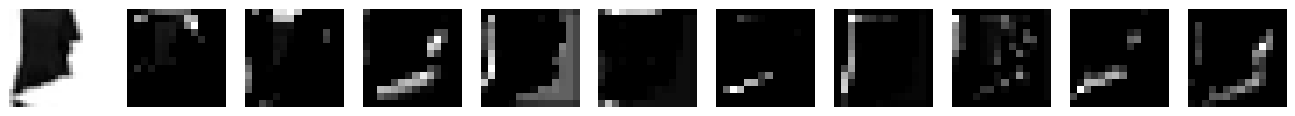

Muestra: 10


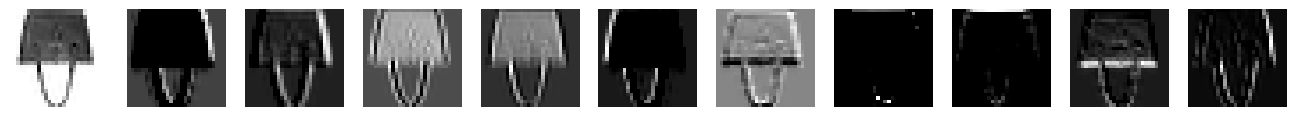

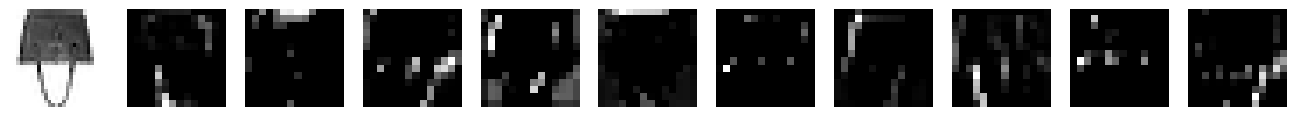

Muestra: 11


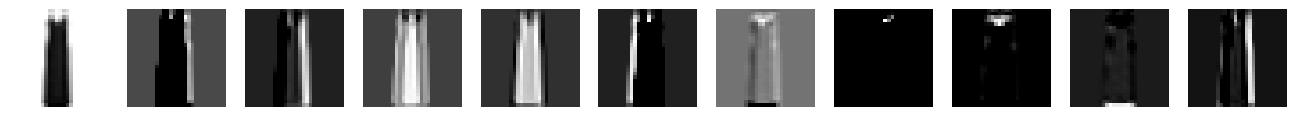

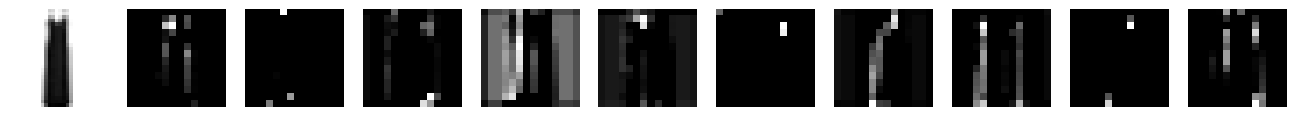

Muestra: 12


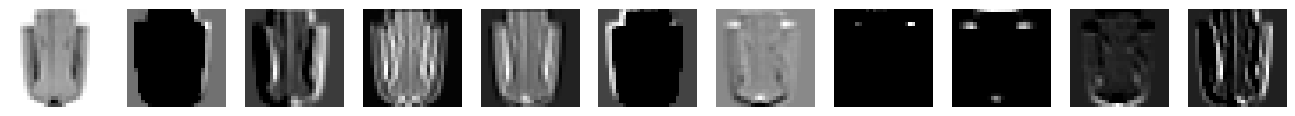

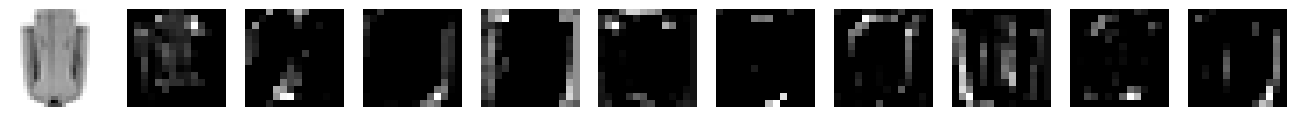

Muestra: 13


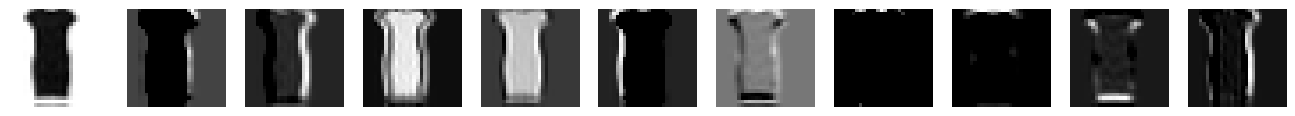

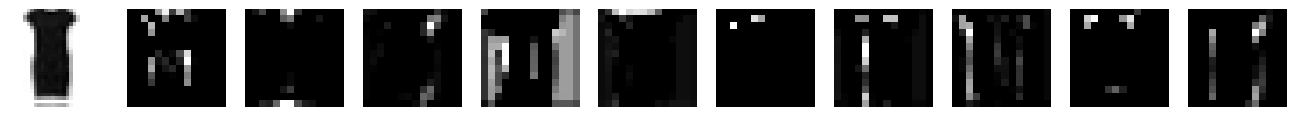

Muestra: 14


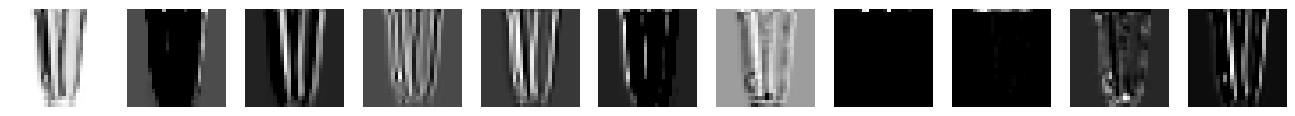

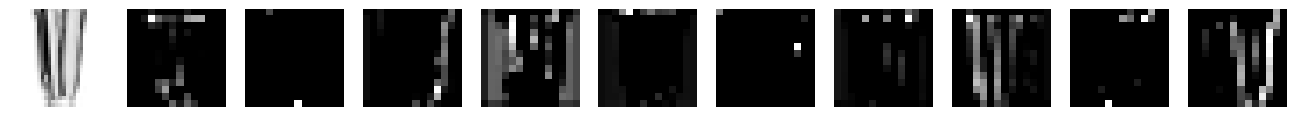

Muestra: 15


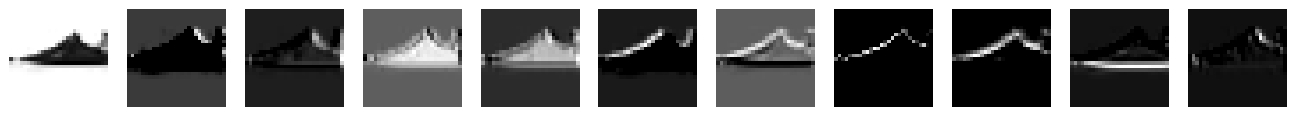

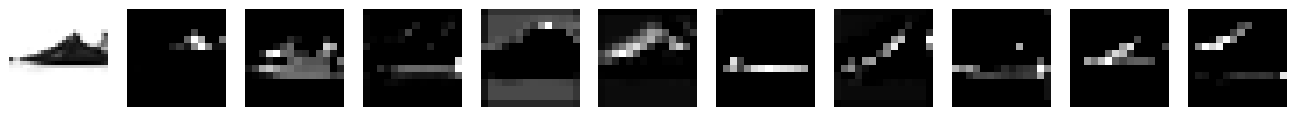

Muestra: 16


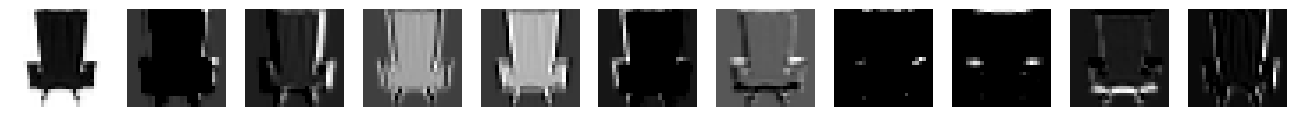

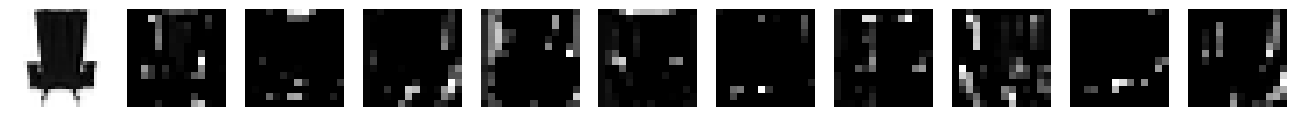

Muestra: 17


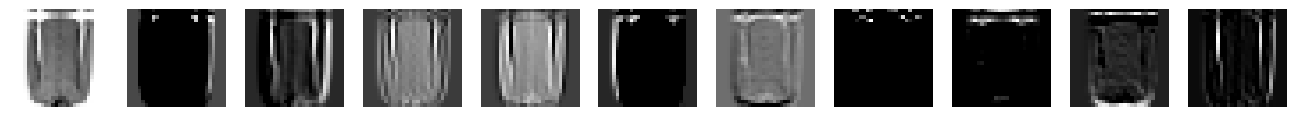

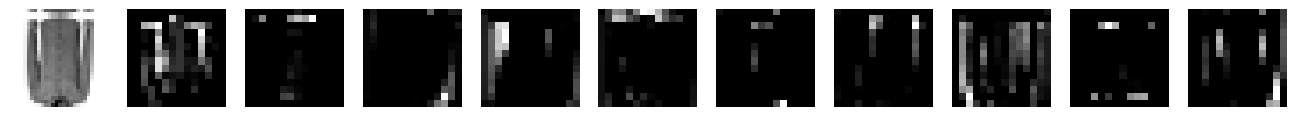

Muestra: 18


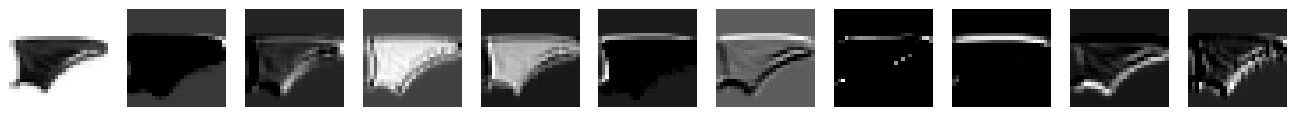

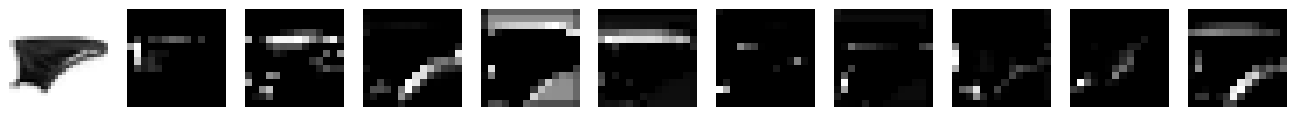

Muestra: 19


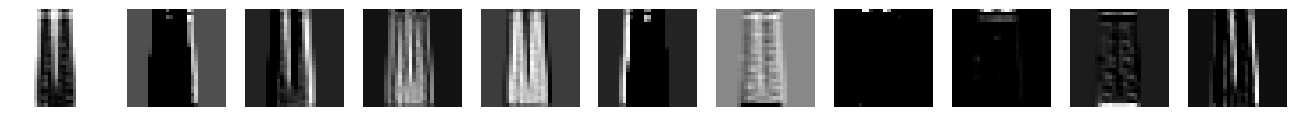

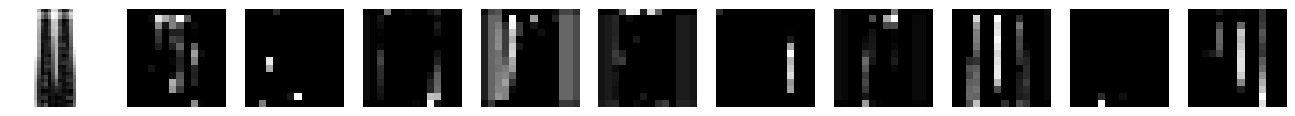

Muestra: 20


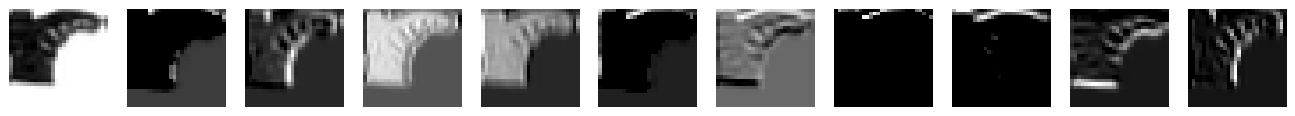

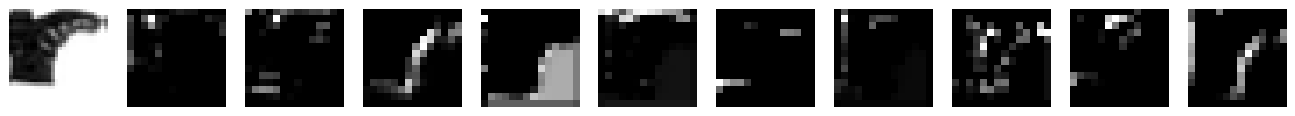

Muestra: 21


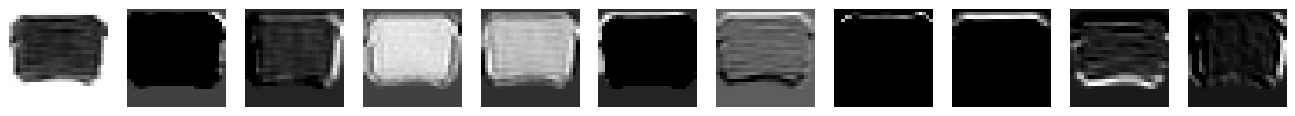

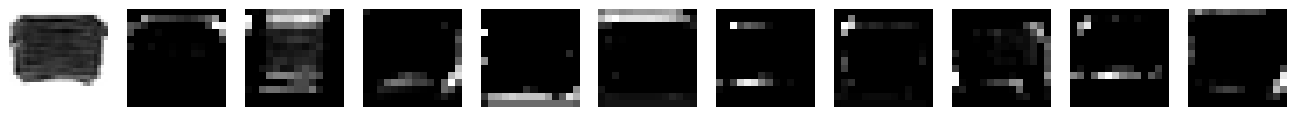

Muestra: 22


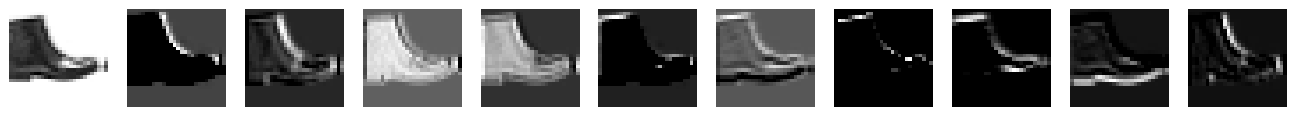

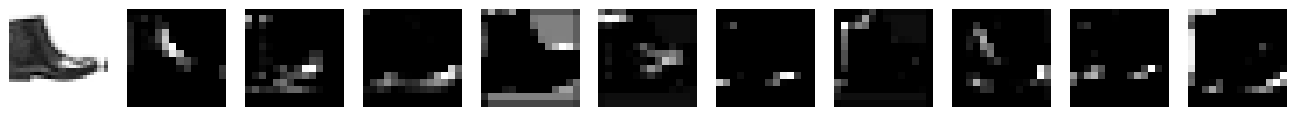

Muestra: 23


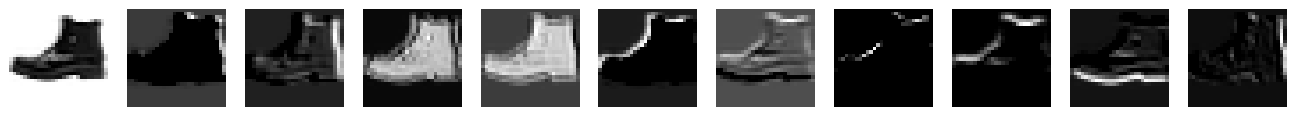

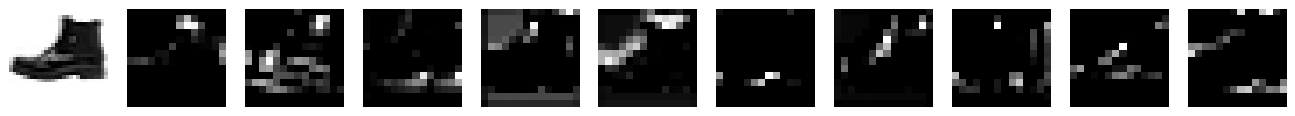

Muestra: 24


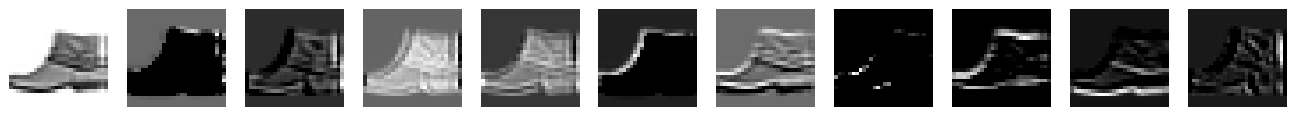

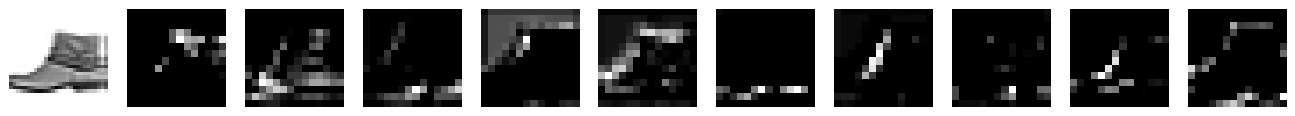

Muestra: 25


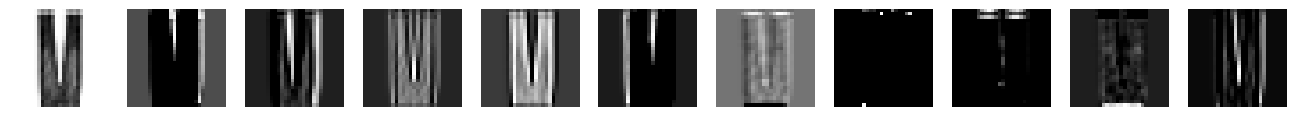

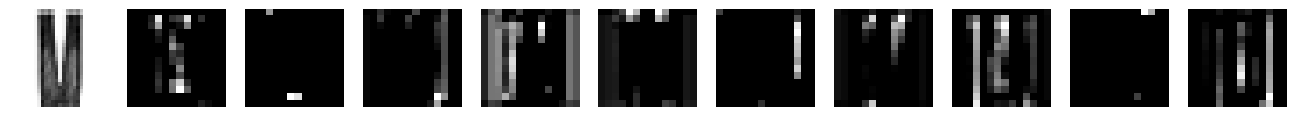

Muestra: 26


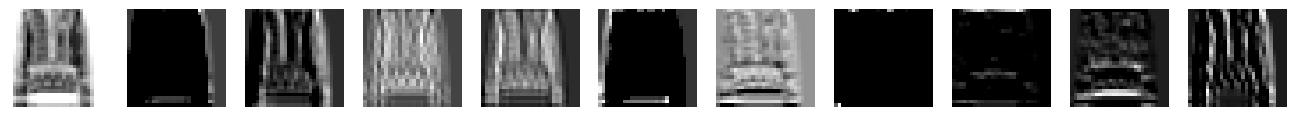

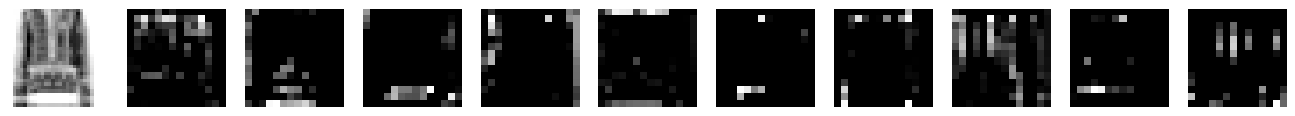

Muestra: 27


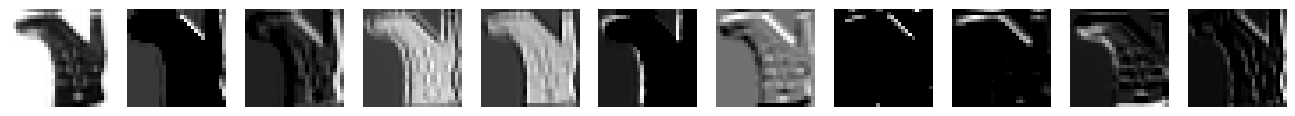

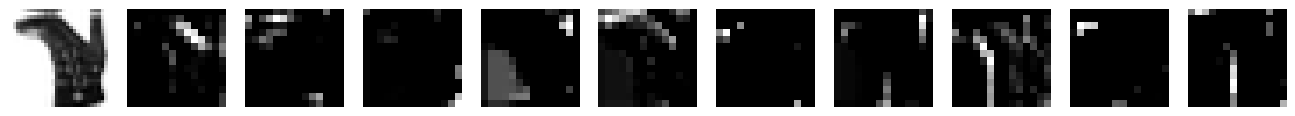

Muestra: 28


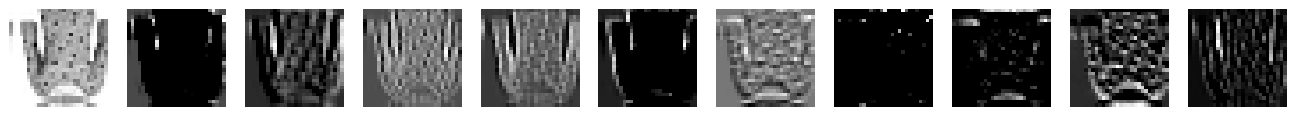

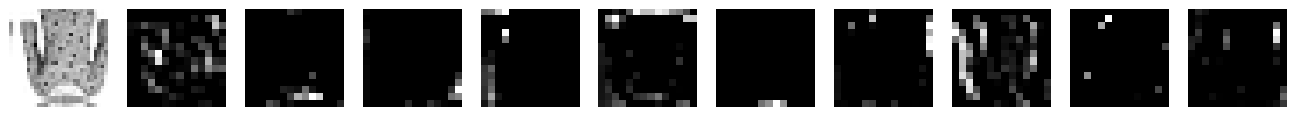

Muestra: 29


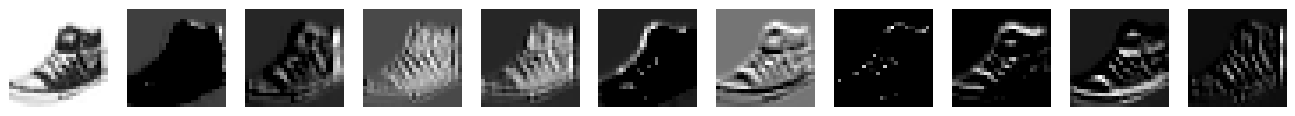

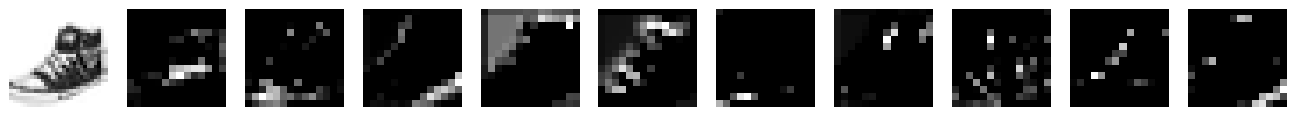

Muestra: 30


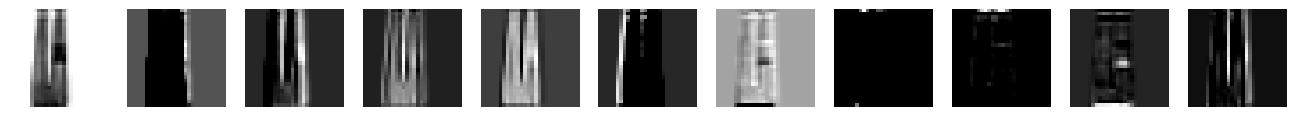

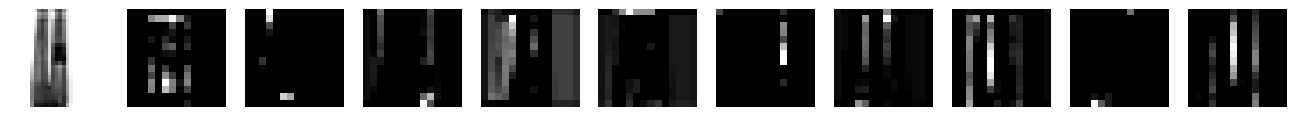

Muestra: 31


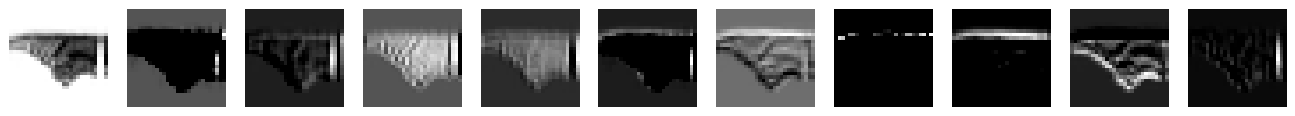

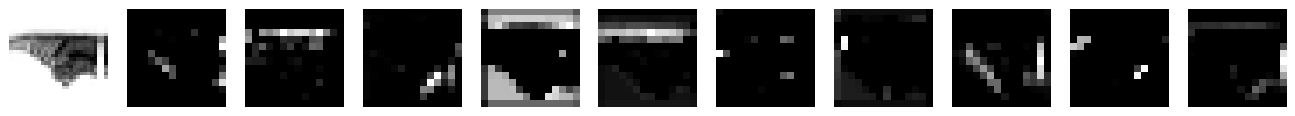

In [32]:
# Obteniendo el primer batch de datos de entrenamiento
x,y = data_gen_train[0]
# Generando los feature maps a partir del modelo entrenado
feature_maps = model_cnn_1.predict(x, verbose=0)
for i_sample in range(x.shape[0]):
  print("Muestra:", i_sample)
  for fmap in feature_maps:
    fmap_i = fmap[i_sample]
    n_fmaps = 10
    # Visualizando la imagen de entrada en la 1era columna
    plt.figure(figsize=(20,10), dpi=90)
    plt.subplot(1,n_fmaps+2,1)
    plt.imshow(x[i_sample], cmap=plt.cm.binary)
    plt.axis("off")
    # Visualización de los 10 primeros feature maps de cada capa
    for i in range(n_fmaps):
      f = fmap_i[:,:,i]
      plt.subplot(1,n_fmaps+2,i+2)
      plt.imshow(f, cmap="gray")
      plt.axis("off")
    plt.show()